In [1]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns

In [3]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [4]:
%matplotlib inline

In [5]:

def get_retino_metadata(experiment='retino', animalids=None,
                        roi_type='manual2D_circle', traceid=None,
                        rootdir='/n/coxfs01/2p-data', 
                        aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):

    sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
   
    meta_list=[]
    for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
        if animalids is not None:
            if animalid not in animalids:
                continue
        exp_list = [e for e in g['experiment'].values if experiment in e] 
        if len(exp_list)==0:
            print('skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment,
                                'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                with open(rid_fpath, 'r') as f:
                    retids = json.load(f)
                traceids = [r for r, res in retids.items() if res['PARAMS']['roi_type']==roi_type] 
                for traceid in traceids: 
                    meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))
            else:
                meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))

    return meta_list



## Some aggregate plotting stuff

In [6]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Select dataset

In [7]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'


# ----------------------------------------------------------------------------------------------------
# Aggregate projection results
This is output of classifications/aggregate_gradient_estimates()


In [8]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
    return

## Set analysis parameters

In [9]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### RF params
responsive_test = None
responsive_thr = None
n_stds = None
response_type = 'dff'
fit_thr=0.5
rf_fit_desc = fitrf.get_fit_desc(response_type=response_type)

#### Filter RF datasets by
rf_filter_by='drop_repeats'

#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.003
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr

##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)


pixels_thr-0.003


In [10]:
# Set data identifiers

retino_dataid = '%s|%s|retinobar-%s' % (fov_type, state, magthr_str)
rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_desc)

data_id = '%s|%s|retinobar-%s|rfs-%s' % (fov_type, state, magthr_str, rf_fit_desc)
print(data_id)


zoom2p0x|awake|retinobar-pixels_thr-0.003|rfs-fit-2dgaus_dff-no-cutoff


# Set output dirs

In [11]:
gradient_dir = os.path.join(aggr_dir, 'retinotopy', 'gradient_analysis')

if not os.path.exists(gradient_dir):
    os.makedirs(gradient_dir)
gradient_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis'

In [12]:
dst_dir = os.path.join(gradient_dir, 'pass_%s' % pass_criterion)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels'

# Load datasets

In [13]:
# Get datasets that have BOTH rfs and retinogradient measured
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
bothdata = pd.concat([g for s, g in sdata.groupby(['animalid', 'session', 'fov']) \
                        if ('retino' in sdata['experiment'].values) and \
                        ('rfs' in sdata['experiment'].values or 'rfs10' in sdata['experiment'].values)])
bothdata['datakey'] = ['_'.join([session, animalid, 'fov%i' % fovnum]) \
                         for (session, animalid, fovnum) in bothdata[['session', 'animalid', 'fovnum']].values]

common_datakeys = bothdata['datakey'].unique()

In [14]:
bothdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 26       26   26
Lm                 22       22   22
V1                 18       18   18

In [15]:
retdata = bothdata[bothdata['experiment']=='retino'].copy()
print("N retinobar experiment fovs:")
print(retdata.groupby(['visual_area']).count())

N retinobar experiment fovs:
             animalid  experiment  fov  session  fovnum  datakey
visual_area                                                     
Li                 23          23   23       23      23       23
Lm                 19          19   19       19      19       19
V1                 15          15   15       15      15       15


In [16]:
print("Threshold info: %s" % magthr_str)
meta_list = get_retino_metadata(experiment='retino', traceid=traceid)

proj_fit_paths=[]; errors=[];
for (animalid, session, fov, retinorun, _) in meta_list:
    # Load data metainfo
    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
    analysis_dir = RETID['DST']
    retinoid = RETID['analysis_id']
    
    datakey = '_'.join([session, animalid, fov, retinorun])
    try:
        fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun,
                                                'retino_analysis', 'retino_structure', 
                                        'projections_%s.pkl' % magthr_str)) # 'projection_results.pkl'))
        assert len(fpaths)==1, "[%s] %i paths found" % (datakey, len(fpaths))
    except Exception as e:
        errors.append(datakey)
        continue
    proj_fit_paths.append((animalid, session, fov, retinorun, retinoid, fpaths[0]))
print("%i of %i paths found" % (len(proj_fit_paths), len(meta_list)))

Threshold info: pixels_thr-0.003
skipping, no retino (JC076, 20190502, FOV1_zoom2p0x)
skipping, no retino (JC091, 20191007, FOV1_zoom2p0x)
skipping, no retino (JC092, 20190527, FOV2_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV1_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV3_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV1_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV4_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV3_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV4_zoom2p0x)
60 of 60 paths found


In [17]:
errors

[]

# Load gradient data

In [19]:
# Create dir to copy gradient images to, for visual inspection
copy_images = True

dst = os.path.join(dst_dir, 'individual_session_inputs')
if not os.path.exists(dst):
    os.makedirs(dst)
    
if copy_images:
    delete_files(dst)
    
print(dst)

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/individual_session_inputs


In [20]:
d_list=[]
for di, (animalid, session, fov, retinorun, retinoid, fpath) in enumerate(proj_fit_paths):
    if di % 20 == 0 or di==(len(proj_fit_paths)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(proj_fit_paths)))
        
    fovnum = int(fov.split('_')[0][3:])
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    with open(fpath, 'rb') as f:
        res = pkl.load(f)
    
    tmpd = res['regr_df'].copy()
    visual_area = retdata[(retdata['animalid']==animalid) 
                          & (retdata['session']==session) 
                          & (retdata['fov']==fov)]['visual_area'].values[0]
    
    metainfo = {'visual_area': visual_area, 'animalid': animalid, 'session': session, 'fov': fov,
               'retinorun': retinorun, 'retinoid': retinoid, 'datakey': datakey, 'fpath':fpath}
    tmpd = putils.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)

    if copy_images:
        src = os.path.split(fpath)[0]
        fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
        for fimpath in fimpaths:
            fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
            shutil.copyfile(fimpath, os.path.join(dst, '%s_%s_%s_%s%s' % (visual_area[0], datakey, retinorun, fname, fext)))
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)

projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

print(projection_df.shape)
projection_df.head()

1 of 60 gradient result files loaded.
21 of 60 gradient result files loaded.
41 of 60 gradient result files loaded.
60 of 60 gradient result files loaded.
(120, 17)


R2       RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
0  0.545824  15.029276     0.049545   az  38.375491        0.0   0.738799   
1  0.747663   6.524156     0.036184   el -18.948086        0.0   0.864675   
2  0.175167   8.945338     0.012529   az   4.287611        0.0   0.418529   
3  0.010267   2.858159     0.000923   el   3.184619        0.0   0.101329   
4  0.991063   1.404291     0.050939   az  42.383800        0.0   0.995521   

     retinorun            fov   session animalid              datakey  \
0  retino_run1  FOV1_zoom2p0x  20190420    JC076  20190420_JC076_fov1   
1  retino_run1  FOV1_zoom2p0x  20190420    JC076  20190420_JC076_fov1   
2  retino_run1  FOV1_zoom2p0x  20190422    JC076  20190422_JC076_fov1   
3  retino_run1  FOV1_zoom2p0x  20190422    JC076  20190422_JC076_fov1   
4  retino_run1  FOV1_zoom2p0x  20190423    JC076  20190423_JC076_fov1   

  visual_area     retinoid                                              fpath  \
0          V1  analysis002  /n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0...   
1          V1  analysis002  /n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0...   
2          Li  analysis002  /n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...   
3          Li  analysis002  /n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0...   
4          Lm  analysis002  /n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0...   

   abs_coef  cortical_mag  
0  0.049545     20.183516  
1  0.036184     27.636162  
2  0.012529     79.816001  
3  0.000923   1082.896855  
4  0.050939     19.631440

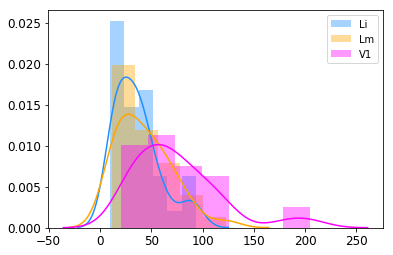

In [21]:
r2_thr=0.5
fig, ax = pl.subplots()
for visual_area, g in projection_df[projection_df['R2']>r2_thr].groupby(['visual_area']):
    sns.distplot(g['cortical_mag'].values, ax=ax, color=area_colors[visual_area], label=visual_area)
ax.legend()

In [442]:
# Load 1 fov to test sth
animalid='JC110'
session = '20191006'
fpath = [p for p in proj_fit_paths if p[0]==animalid and p[1]==session and p[3]=='retino_run1'][0][5]
print(fpath)
with open(fpath, 'rb') as f:
    res = pkl.load(f)
print(res['regr_az'].coef_, res['regr_az'].intercept_)
p_df = res['regr_df'].copy()
print(p_df)

# gradient info
grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(grad_fpath, 'rb') as f:
    gresults = pkl.load(f)
gresults.keys()


/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_5ae341/retino-structure/projection_results.pkl
(array([[ 0.02216148]]), array([ 19.95735156]))
         R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r
0  0.928207  1.648383     0.022161   az  19.957352        0.0   0.963435
1  0.969433  0.526419     0.010254   el -12.249892        0.0   0.984598


['el', 'az']

# Cortical magnification

In [111]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', fontsize=10, fontcolor='k', 
                          area_colors=None, legend=True):

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor)
    
    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)

    if legend:
        # Get counts of samples for legend
        legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.4,1.2), fontsize=8)

    return fig


In [23]:
def plot_axis_distributions(projdf, currmetric='abs_coef', hue='cond',
                            currcols=['windows blue', 'amber'], 
                             fontsize=10, fontcolor='k', area_colors=None):

    bi_palette = sns.xkcd_palette(currcols)

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    sns.stripplot(x='visual_area', y=currmetric, hue=hue, data=projdf, 
                  dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                 order=['V1', 'Lm', 'Li'])
    #if barplot:
    sns.barplot("visual_area", currmetric, data=projdf,
               hue=hue, order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    #ax.set_ylim([0, 0.12])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
    pl.legend(bbox_to_anchor=((1.2, 1)))
    projdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor)

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(projdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.2), fontsize=8)

    return fig

# Filter retino gradient results
- (Set some R2 threshold)
- "Bad" fits suggests that the retino gradient was messed up or points were all over the place?
- Also, drop extra run (retino_run1, and retino_run2)
- May have duplicate FOVS.

In [24]:
projection_df[['visual_area', 'datakey', 'retinorun']].drop_duplicates().groupby(['visual_area']).count()

datakey  retinorun
visual_area                    
Li                24         24
Lm                20         20
V1                16         16

In [25]:
repeat_retinos = pd.concat([g for k, g in projection_df.groupby(['visual_area', 'datakey']) \
                            if len(g['retinorun'].unique())>1], axis=0)


In [26]:
repeat_retinos.groupby(['visual_area', 'datakey']).count()

R2  RMSE  coefficient  cond  intercept  \
visual_area datakey                                                       
Li          20190605_JC090_fov1   4     4            4     4          4   
Lm          20190508_JC083_fov1   4     4            4     4          4   
            20190525_JC084_fov1   4     4            4     4          4   
V1          20190507_JC083_fov1   4     4            4     4          4   
            20190522_JC084_fov1   4     4            4     4          4   

                                 pearson_p  pearson_r  retinorun  fov  \
visual_area datakey                                                     
Li          20190605_JC090_fov1          4          4          4    4   
Lm          20190508_JC083_fov1          4          4          4    4   
            20190525_JC084_fov1          4          4          4    4   
V1          20190507_JC083_fov1          4          4          4    4   
            20190522_JC084_fov1          4          4          4    4   

                                 session  animalid  retinoid  fpath  abs_coef  \
visual_area datakey                                                             
Li          20190605_JC090_fov1        4         4         4      4         4   
Lm          20190508_JC083_fov1        4         4         4      4         4   
            20190525_JC084_fov1        4         4         4      4         4   
V1          20190507_JC083_fov1        4         4         4      4         4   
            20190522_JC084_fov1        4         4         4      4         4   

                                 cortical_mag  
visual_area datakey                            
Li          20190605_JC090_fov1             4  
Lm          20190508_JC083_fov1             4  
            20190525_JC084_fov1             4  
V1          20190507_JC083_fov1             4  
            20190522_JC084_fov1             4

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'compare_runs_retinograd_pixels_thr-0.003')


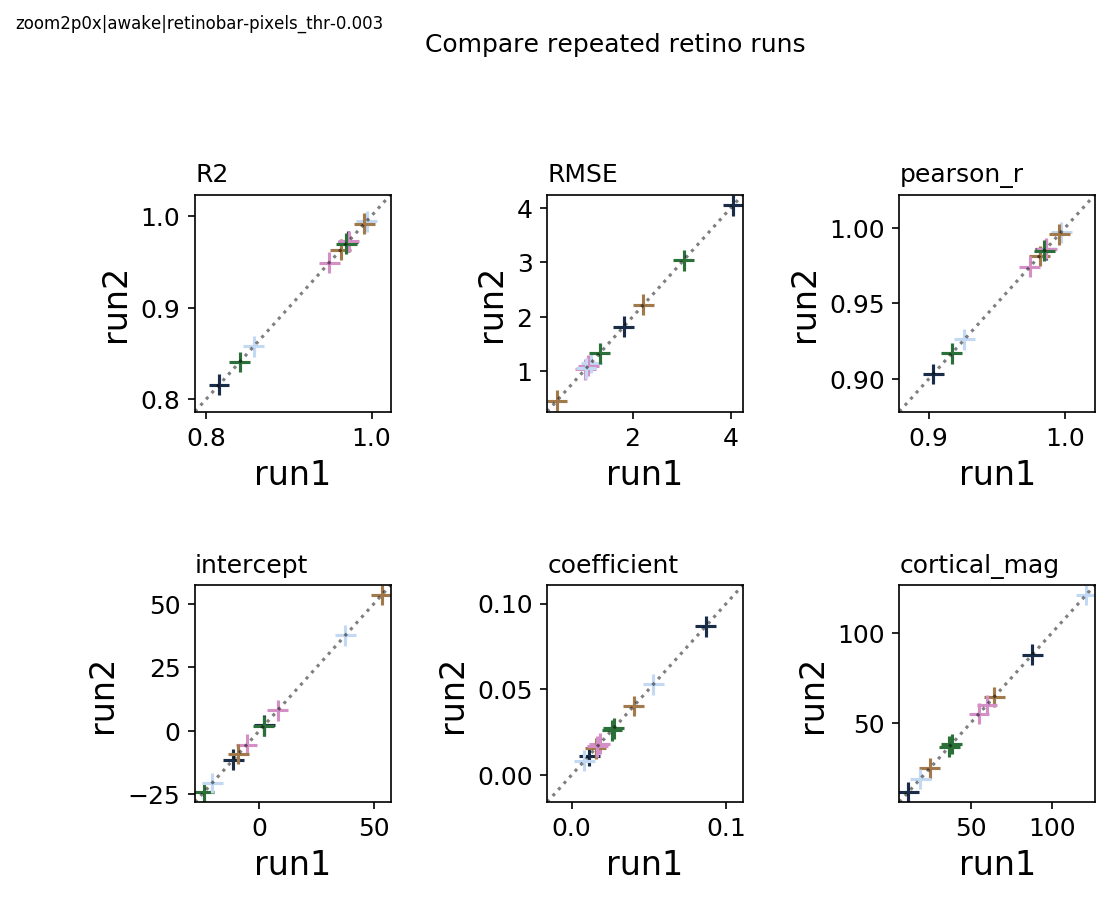

In [27]:
fig, axn = pl.subplots(2, 3, figsize=(8,6), dpi=dpi)
dkey_colors = sns.color_palette('cubehelix', n_colors=len(repeat_retinos['datakey'].unique()))

params=['R2', 'RMSE', 'pearson_r', 'intercept', 'coefficient', 'cortical_mag']
for ax, p in zip(axn.flat, params):
    currx = repeat_retinos[repeat_retinos['retinorun']=='retino_run1'][p].values
    curry = repeat_retinos[repeat_retinos['retinorun']=='retino_run2'][p].values
    ax.scatter(currx, curry, c=dkey_colors, marker='+', s=100)
    ax.set_title(p, loc='left', fontsize=12)
    ax.set_ylabel('run2')
    ax.set_xlabel('run1')
    max_lim = max([ax.get_ylim()[1], ax.get_xlim()[1]])
    min_lim = min([ax.get_ylim()[0], ax.get_xlim()[0]])
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k:', alpha=0.5)
pl.subplots_adjust(left=0.15, right=0.9, hspace=0.8, wspace=0.8, top=0.8)
fig.suptitle("Compare repeated retino runs")

label_figure(fig, retino_dataid)
figname = 'compare_runs_retinograd_%s' % (magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

# Remove repeat runs

In [28]:
gradient_df = pd.concat([g[g['retinorun']=='retino_run2'] if len(g['retinorun'].unique())>1 else g for k, g in projection_df.groupby(['visual_area', 'datakey'])], axis=0)
gradient_df['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun in gradient_df[['datakey', 'retinorun']].values]
print(projection_df.shape, gradient_df.shape)


((120, 17), (110, 18))


# Filter FOVs, only select good gradient fits

In [311]:
r2_thr=0.5
all_retino_datakeys = gradient_df['datakey'].unique()
    
# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in gradient_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) and (g[g['cond']=='el']['R2'].values > r2_thr))])
print(gradient_df.shape, projdf.shape)


((110, 18), (74, 18))


In [312]:
pass_retino_datakeys = projdf['datakey'].unique()
fail_retino_datakeys = [r for r in projection_df['datakey'].unique() if r not in pass_retino_datakeys]
print("%i of %i retinokeys pass threshold (R2=%.2f)" % (len(pass_retino_datakeys), len(all_retino_datakeys), r2_thr))


37 of 55 retinokeys pass threshold (R2=0.50)


### Cortical mag, PAIRED

V1: (t-stat:-4.82, p=0.00)
Lm: (t-stat:-6.40, p=0.00)
Li: (t-stat:-3.99, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'cortical_mag_paired__R2-0.50_pixels_thr-0.003')


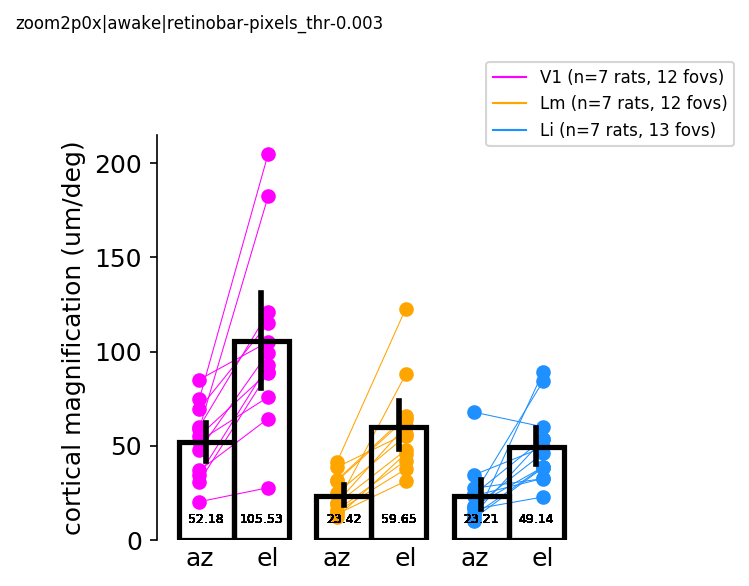

In [314]:
metric = 'cortical_mag'
#metric = 'abs_coef'

fig = plot_pairwise_by_axis(projdf, curr_metric=metric, c1='az', c2='el',
                           area_colors=area_colors, fontsize=6, fontcolor='k')
pl.subplots_adjust(left=0.2, right=0.75, top=0.8)
if metric=='abs_coef':
    pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)
else:
    pl.ylabel('cortical magnification (um/deg)', fontsize=12)

label_figure(fig, retino_dataid)
figname = '%s_paired__%s_%s' % (metric, fit_str, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

### Plot means, rather than splitting cond

In [315]:
gradient_means = projdf.groupby(['visual_area', 'retinokey']).mean().reset_index()

********* [cortical_mag] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.002 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.001 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.215 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'avg_cortical_mag__R2-0.50_pixels_thr-0.003')


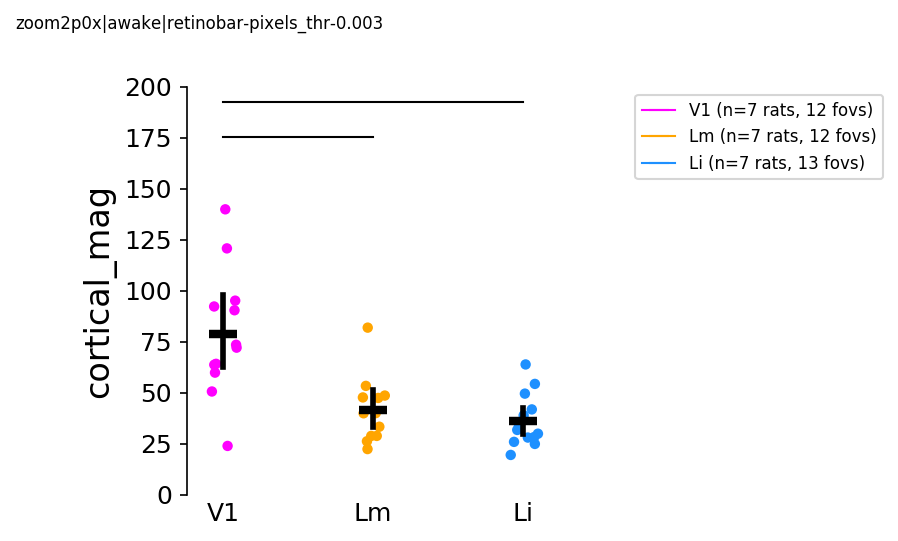

In [316]:
multi_comp_test = 'fdr_bh'
fig, ax = pl.subplots(dpi=dpi, figsize=(6,4))

sns.stripplot(x='visual_area', y='cortical_mag', data=gradient_means,
             ax=ax, palette=area_colors, zorder=0, order=visual_areas)
sns.pointplot(x='visual_area', y='cortical_mag', data=gradient_means,
             ax=ax, join=False, scale=2, markers='_', color='k',zorder=0, order=visual_areas)

statresults, ax = aggr.plot_mannwhitney(gradient_means, metric='cortical_mag', #y_loc=160,
                                        multi_comp_test=multi_comp_test, ax=ax)
ax.set_ylim([0, 200])
ax.tick_params(axis='x', which='both', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True, offset=4)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.6)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.2,1), fontsize=8)

label_figure(fig, retino_dataid)
figname = 'avg_cortical_mag__%s_%s' % (fit_str, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

### Compare by area, for each axis

********* [cortical_mag] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.001 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.001 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.266 (fdr_bh), reject H0=False
****************************
********* [cortical_mag] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.005 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.002 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.111 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'avg_cortical_mag_split-cond__R2-0.50_pixels_thr-0.003')


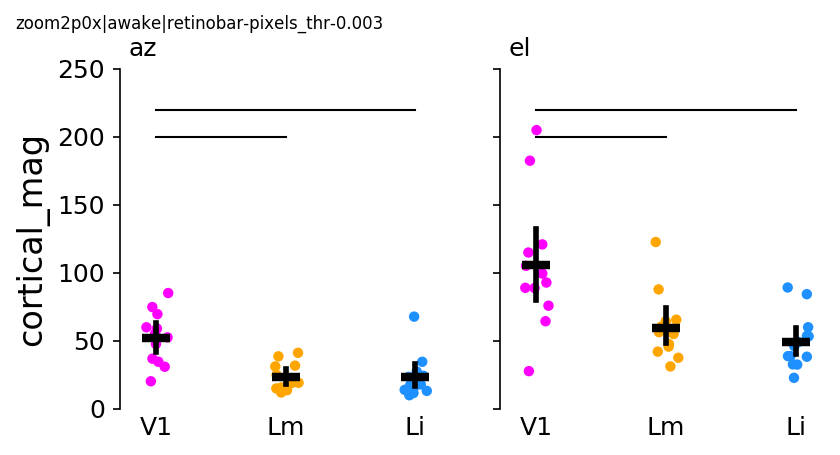

In [317]:
multi_comp_test = 'fdr_bh'
fig, axn = pl.subplots(1, 2, dpi=dpi, figsize=(6,3), sharex=True, sharey=True)

for ax, (cond, cond_df) in zip(axn.flat, projdf.groupby(['cond'])):

    sns.stripplot(x='visual_area', y='cortical_mag', data=cond_df,
                 ax=ax, palette=area_colors, zorder=0, order=visual_areas)
    sns.pointplot(x='visual_area', y='cortical_mag', data=cond_df,
                 ax=ax, join=False, scale=2, markers='_', color='k',zorder=0, order=visual_areas)

    statresults, ax = aggr.plot_mannwhitney(cond_df, metric='cortical_mag', y_loc=200, offset=20,
                                            multi_comp_test=multi_comp_test, ax=ax, )
    ax.tick_params(axis='x', which='both', size=0)
    #pl.subplots_adjust(left)
    ax.set_title(cond, loc='left', fontsize=12)
    ax.set_xlabel('')
ax.set_ylim([0, 250])
sns.despine(bottom=True, trim=True, offset=4)
axn[1].set_ylabel('')


label_figure(fig, retino_dataid)
figname = 'avg_cortical_mag_split-cond__%s_%s' % (fit_str, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

### Cortical mag, either axis passes

In [318]:
r2_thr=0.5
# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in projection_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) or (g[g['cond']=='el']['R2'].values > r2_thr))])


In [319]:
retino_dataid

'zoom2p0x|awake|retinobar-pixels_thr-0.003'

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'cortical_mag__R2-0.50_pixels_thr-0.003')


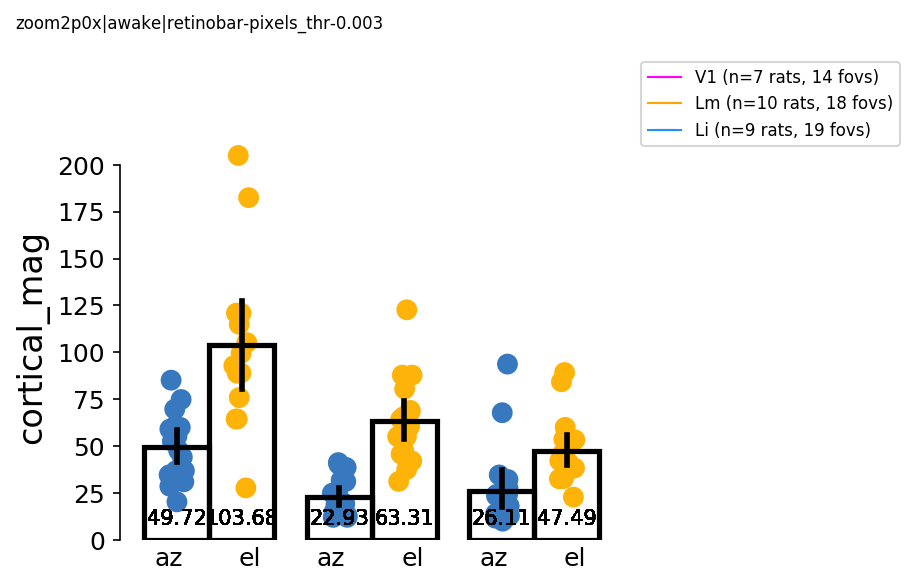

In [322]:
#currmetric='abs_coef'
currmetric = 'cortical_mag'

hue='cond'
currcols = ['windows blue', 'amber']
fig = plot_axis_distributions(projdf[projdf['R2']>r2_thr], currmetric=currmetric, hue=hue,
                            currcols=currcols, area_colors=area_colors)
label_figure(fig, retino_dataid)

pl.subplots_adjust(left=0.15, right=0.8, top=0.8)

figname = '%s__R2-%.2f_%s' % (currmetric, r2_thr, magthr_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

# Scatter

In [29]:
from pipeline.python.rois.utils import load_roi_coords

In [30]:
def get_rf_dataframe(filter_by=None, fit_thr=0.5, traceid='traces001',
                    fit_desc='fit-2dgaus_dff-no-cutoff', fov_type='zoom2p0x',
                    state='awake', stimulus='rfs', verbose=False):
    
    #### Get non-repeated FOV datasets
    r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                      traceid=traceid, fit_desc=fit_desc,
                                                      reliable_only=reliable_only, verbose=verbose,
                                                      fov_type=fov_type, state=state, stimulus=stimulus)

    #### Split fx, fy for theta comp
    r_df['fx'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.cos(r_df['theta']))
    r_df['fy'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.sin(r_df['theta']))
    r_df['ratio_xy'] = r_df['std_x']/r_df['std_y']

    # Convert thetas to [-90, 90]
    thetas = [(t % np.pi) - np.pi if ((np.pi/2.)<t<(np.pi) or (((3./2)*np.pi)<t<2*np.pi)) \
              else (t % np.pi) for t in r_df['theta'].values]
    r_df['theta_c'] = thetas

    return r_df

In [31]:
def abline(slope, intercept, ax=None, color='purple', ls='-',
           label=True, label_prefix=''):
    """Plot a line from slope and intercept"""
    if ax is None:
        fig, ax = pl.subplots()
    #axes = plt.gca()
    #x_vals = np.array(axes.get_xlim())
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    label_str = '(%s) y=%.2fx+%.2f' % (label_prefix, slope, intercept) if label else None
    ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls)
    ax.legend()
    return ax

### Select RF dataset filters

In [32]:
rf_filter_by

'drop_repeats'

In [229]:
#rf_filter_by = None # 'drop_repeats'
rf_filter_by = 'drop_repeats'

reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

rf_fit_str = '%s_%s' % (rf_filter_by, reliable_str)

rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_str)
print(rf_dataid)


zoom2p0x|awake|rfs-drop_repeats_reliable


In [230]:
rf_fit_desc

'fit-2dgaus_dff-no-cutoff'

In [231]:
# Set data identifiers

#retino_dataid = '%s|%s|retinobar-%s' % (fov_type, state, magthr_str)
#rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_desc)

data_id = '%s|%s|retinobar-%s|rfs-%s' % (fov_type, state, magthr_str, rf_fit_str)
print(data_id)


zoom2p0x|awake|retinobar-pixels_thr-0.003|rfs-drop_repeats_reliable


# Load cell positions (and RF info)

In [232]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(aggr_rf_dir):
    os.makedirs(aggr_rf_dir)
print("... saving output to base dir:\n%s" % aggr_rf_dir)


... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [233]:
#df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s*.pkl' % (rf_filter_by, reliable_str)))


['/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_rfs10.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_r_df.pkl']

In [234]:
df_fpath = glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s*.pkl' % (rf_filter_by, reliable_str)))[2]
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_r_df.pkl


In [235]:
get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            rf_df = pkl.load(f)
        if isinstance(rf_df, dict):
            rf_df = rf_df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

Loading existing RF coord conversions...
False


In [236]:
rf_df.groupby(['visual_area', 'datakey', 'experiment']).count()

r2  fwhm_x  fwhm_y  theta   x0  \
visual_area datakey             experiment                                    
Li          20190502_JC076_fov1 rfs          19      19      19     19   19   
            20190522_JC089_fov1 rfs           3       3       3      3    3   
                                rfs10         6       6       6      6    6   
            20190527_JC092_fov2 rfs10        14      14      14     14   14   
            20190527_JC092_fov3 rfs10        42      42      42     42   42   
            20190528_JC092_fov1 rfs10         7       7       7      7    7   
            20190605_JC090_fov1 rfs10        17      17      17     17   17   
            20190607_JC091_fov1 rfs10        69      69      69     69   69   
            20190612_JC099_fov1 rfs10        40      40      40     40   40   
            20190614_JC091_fov1 rfs10        99      99      99     99   99   
            20190617_JC099_fov1 rfs10        11      11      11     11   11   
            20191003_JC111_fov1 rfs10        11      11      11     11   11   
            20191007_JC091_fov1 rfs          19      19      19     19   19   
                                rfs10        21      21      21     21   21   
            20191008_JC091_fov1 rfs10        46      46      46     46   46   
            20191018_JC113_fov1 rfs10        13      13      13     13   13   
            20191105_JC117_fov1 rfs10        10      10      10     10   10   
            20191111_JC120_fov1 rfs10         4       4       4      4    4   
Lm          20190423_JC076_fov1 rfs          15      15      15     15   15   
            20190509_JC078_fov1 rfs          15      15      15     15   15   
            20190513_JC078_fov1 rfs          19      19      19     19   19   
            20190517_JC083_fov1 rfs          23      23      23     23   23   
            20190525_JC084_fov1 rfs          38      38      38     38   38   
            20190602_JC080_fov2 rfs10        34      34      34     34   34   
            20190603_JC080_fov1 rfs          57      57      57     57   57   
            20190618_JC097_fov1 rfs          14      14      14     14   14   
                                rfs10        28      28      28     28   28   
            20190627_JC091_fov1 rfs           9       9       9      9    9   
            20191004_JC110_fov3 rfs10        11      11      11     11   11   
            20191004_JC110_fov4 rfs10        19      19      19     19   19   
            20191012_JC113_fov3 rfs10        18      18      18     18   18   
            20191104_JC117_fov2 rfs10        50      50      50     50   50   
            20191106_JC120_fov4 rfs10         8       8       8      8    8   
            20191111_JC117_fov2 rfs10         2       2       2      2    2   
V1          20190420_JC076_fov1 rfs          36      36      36     36   36   
            20190511_JC083_fov1 rfs          44      44      44     44   44   
            20190522_JC084_fov1 rfs         130     130     130    130  130   
            20190613_JC097_fov1 rfs          67      67      67     67   67   
                                rfs10       107     107     107    107  107   
            20190616_JC097_fov1 rfs         102     102     102    102  102   
                                rfs10       131     131     131    131  131   
            20190617_JC097_fov1 rfs          89      89      89     89   89   
            20190622_JC085_fov1 rfs          27      27      27     27   27   
                                rfs10       115     115     115    115  115   
            20191006_JC110_fov1 rfs          48      48      48     48   48   
                                rfs10        87      87      87     87   87   
            20191106_JC120_fov3 rfs10        66      66      66     66   66   
            20191111_JC117_fov1 rfs10        21      21      21     21   21   

                                             y0  animalid  cell  fovnum  \
visual_area datakey

In [237]:
if get_positions:
    # Get RF fit info first
    rf_df = get_rf_dataframe(filter_by=filter_by, reliable_only=reliable_only,
                     fit_thr=fit_thr, traceid=traceid, fit_desc=fit_desc,
                    verbose=False, fov_type=fov_type, state=state, stimulus='rfs')
    
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rf_df[p] = ''
    
    # Add fov coord info and save
    p_list=[]
    for (animalid, session, fovnum, exp), g in rf_df.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rf_df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(rf_df, f, protocol=pkl.HIGHEST_PROTOCOL)

In [238]:
# no_retino=[]
# for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
#     if (projdf[projdf['datakey']==datakey].shape[0])==0:
#         no_retino.append((visual_area, datakey))
# for r in no_retino:
#     print r
    

In [240]:
rf_df.groupby(['visual_area', 'datakey', 'experiment']).count()

r2  fwhm_x  fwhm_y  theta   x0  \
visual_area datakey             experiment                                    
Li          20190502_JC076_fov1 rfs          19      19      19     19   19   
            20190522_JC089_fov1 rfs           3       3       3      3    3   
                                rfs10         6       6       6      6    6   
            20190527_JC092_fov2 rfs10        14      14      14     14   14   
            20190527_JC092_fov3 rfs10        42      42      42     42   42   
            20190528_JC092_fov1 rfs10         7       7       7      7    7   
            20190605_JC090_fov1 rfs10        17      17      17     17   17   
            20190607_JC091_fov1 rfs10        69      69      69     69   69   
            20190612_JC099_fov1 rfs10        40      40      40     40   40   
            20190614_JC091_fov1 rfs10        99      99      99     99   99   
            20190617_JC099_fov1 rfs10        11      11      11     11   11   
            20191003_JC111_fov1 rfs10        11      11      11     11   11   
            20191007_JC091_fov1 rfs          19      19      19     19   19   
                                rfs10        21      21      21     21   21   
            20191008_JC091_fov1 rfs10        46      46      46     46   46   
            20191018_JC113_fov1 rfs10        13      13      13     13   13   
            20191105_JC117_fov1 rfs10        10      10      10     10   10   
            20191111_JC120_fov1 rfs10         4       4       4      4    4   
Lm          20190423_JC076_fov1 rfs          15      15      15     15   15   
            20190509_JC078_fov1 rfs          15      15      15     15   15   
            20190513_JC078_fov1 rfs          19      19      19     19   19   
            20190517_JC083_fov1 rfs          23      23      23     23   23   
            20190525_JC084_fov1 rfs          38      38      38     38   38   
            20190602_JC080_fov2 rfs10        34      34      34     34   34   
            20190603_JC080_fov1 rfs          57      57      57     57   57   
            20190618_JC097_fov1 rfs          14      14      14     14   14   
                                rfs10        28      28      28     28   28   
            20190627_JC091_fov1 rfs           9       9       9      9    9   
            20191004_JC110_fov3 rfs10        11      11      11     11   11   
            20191004_JC110_fov4 rfs10        19      19      19     19   19   
            20191012_JC113_fov3 rfs10        18      18      18     18   18   
            20191104_JC117_fov2 rfs10        50      50      50     50   50   
            20191106_JC120_fov4 rfs10         8       8       8      8    8   
            20191111_JC117_fov2 rfs10         2       2       2      2    2   
V1          20190420_JC076_fov1 rfs          36      36      36     36   36   
            20190511_JC083_fov1 rfs          44      44      44     44   44   
            20190522_JC084_fov1 rfs         130     130     130    130  130   
            20190613_JC097_fov1 rfs          67      67      67     67   67   
                                rfs10       107     107     107    107  107   
            20190616_JC097_fov1 rfs         102     102     102    102  102   
                                rfs10       131     131     131    131  131   
            20190617_JC097_fov1 rfs          89      89      89     89   89   
            20190622_JC085_fov1 rfs          27      27      27     27   27   
                                rfs10       115     115     115    115  115   
            20191006_JC110_fov1 rfs          48      48      48     48   48   
                                rfs10        87      87      87     87   87   
            20191106_JC120_fov3 rfs10        66      66      66     66   66   
            20191111_JC117_fov1 rfs10        21      21      21     21   21   

                                             y0  animalid  cell  fovnum  \
visual_area datakey

#### Test single FOV with above fits, after loading RF stuff

In [331]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )


fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

In [585]:
# Load 1 fov to test sth
animalid='JC085'
session = '20190622'
fpath = [p for p in proj_fit_paths if p[0]==animalid and p[1]==session and p[3]=='retino_run1'][0][5]
print(fpath)
with open(fpath, 'rb') as f:
    res = pkl.load(f)
print(res['regr_az'].coef_, res['regr_az'].intercept_)
p_df = res['regr_df'].copy()
print(p_df)

# gradient info
grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(grad_fpath, 'rb') as f:
    gresults = pkl.load(f)
gresults.keys()


/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037/retino-structure/projection_results.pkl
(array([[ 0.00689552]]), array([ 28.9482809]))
         R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r
0  0.474316  2.214660     0.006896   az  28.948281        0.0   0.688706
1  0.942234  0.691157     0.009458   el -14.141244        0.0   0.970687


['el', 'az']

Text(0.5,0.98,u'Lm')

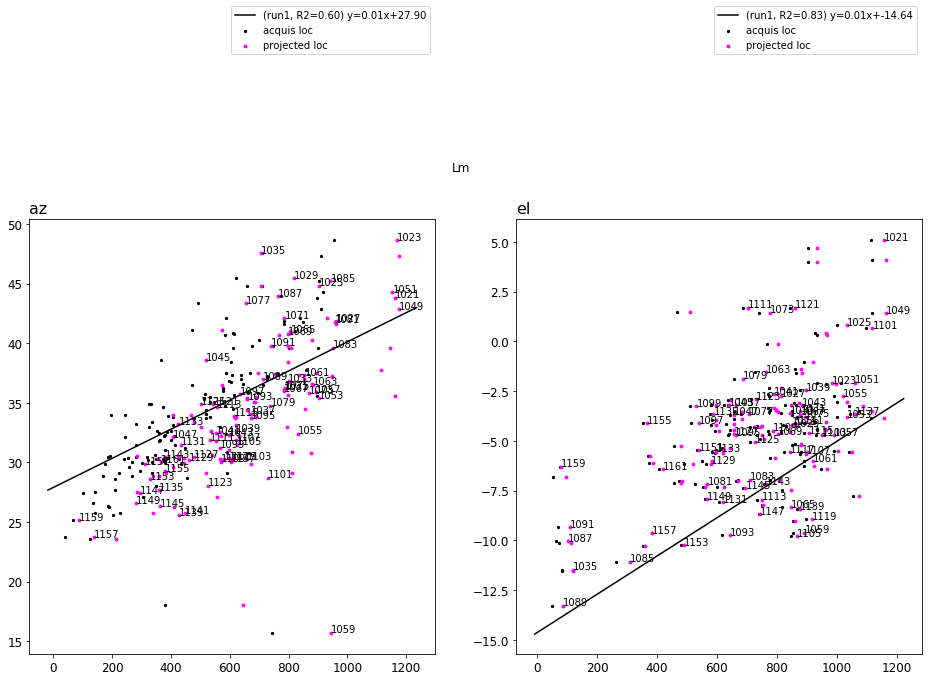

In [607]:
did_above=True
datakey = '20190622_JC085_fov1' #'20190522_JC084_fov1' #'20190607_JC091_fov1'
retinorun = 'retino_run1'

rf_ = rfdf[rfdf['datakey']==datakey].copy()
ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]

#vhat_az = gresults['az']['vhat']
#vhat_el = gresults['el']['vhat']

fig, axn = pl.subplots(1,2, figsize=(16,8))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml' if cond=='az' else 'ap'
    yname = 'x0' if cond=='az' else 'y0'
    vhat_ = vhat_az if cond=='az' else vhat_el
    if did_above:
        ret_ = ret_az[~np.isnan(ret_az)] if cond=='az' else ret_el[~np.isnan(ret_el)]
        regr_ = regr_az if cond=='az' else regr_el
        fitv_ = fitv_az if cond=='az' else fitv_el
    #print(cond, vhat_)
    
    cell_locs = rf_['%s_pos' % xname].values
    rf_locs = rf_['%s' % yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='acquis loc')

    #proj_locs = rfdf[rfdf['datakey']==datakey]['%s_proj' % xname].values
    #ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='dodgerblue')    
    
    # Plot projected points, not abs
    proj_locs2 = np.array([np.dot(np.array((ml, ap)), vhat_) \
                          for ap, ml in rf_[['ap_pos', 'ml_pos']].values])
    ax.scatter(proj_locs2, rf_locs, marker='o', s=8, color='magenta', label='projected loc')   
    
    # Label cells
    label_int=2
    for ri, cellid in enumerate(rf_.index.tolist()[0::label_int]):
        ax.text(proj_locs2[0::label_int][ri], rf_locs[0::label_int][ri], cellid)

    # Plot retino direction
    if did_above:
        slope = float(regr_.coef_) 
        intercept = float(regr_.intercept_) 
        r2_v = skmetrics.r2_score(ret_, fitv_) 
    else:
        slope = float(ret_[ret_['cond']==cond]['coefficient'])
        intercept = float(ret_[ret_['cond']==cond]['intercept'])
        r2_v = float(ret_[ret_['cond']==cond]['R2'])
    label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)
    ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix)

   #ax.invert_yaxis()
    ax.set_title(cond, loc='left', size=16)
    ax.legend(bbox_to_anchor=(1.,1.5))
    
pl.suptitle(currvs['visual_area'].unique()[0])

# Filter dfs: Only include dsets with both retino + rfs/rfs10 measured.
#### Also filter retino gradient df to only include dsets that have good fits (i.e., R2 > thr means retino direction well enough estimated or consistent enough to get a good projection)
NOTE:  TODO, check bad-fit retino dsets, since these may be split FOVs

In [241]:
retino_datakeys = gradient_df['datakey'].unique()
rf_datakeys = rf_df['datakey'].unique()
common_datakeys = np.intersect1d(gradient_df['datakey'].unique(), rf_df['datakey'].unique())

print("Retino: %i, RFs: %i, Common: %i" % (len(retino_datakeys), len(rf_datakeys), len(common_datakeys)))

Retino: 55, RFs: 41, Common: 35


In [242]:
# pass_regr_datakeys = projdf['datakey'].unique()
#rfdf = df[df['datakey'].isin(pass_regr_datakeys)].copy()
rfdf = rf_df[rf_df['datakey'].isin(common_datakeys)].copy()
print("RFs:")
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

projdf = gradient_df[gradient_df['datakey'].isin(common_datakeys)].copy()
print("retinogradients:")
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

RFs:
             datakey
visual_area         
Li                13
Lm                13
V1                 9
retinogradients:
             datakey
visual_area         
Li                13
Lm                13
V1                 9


In [243]:
retino_r2 = 0.75
retino_pass_crit='both'
if retino_pass_crit=='both':
    projdf_filtered = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2) and (g[g['cond']=='el']['R2'].values > retino_r2))])
else:
    projdf_filtered = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2) or (g[g['cond']=='el']['R2'].values > retino_r2))])    
print("retinogradients (filt): %.2f, %s" % (retino_r2, retino_pass_crit))
print(projdf_filtered[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

retinogradients (filt): 0.75, both
             datakey
visual_area         
Li                 6
Lm                 6
V1                 8


In [244]:
#filter_by, fit_str, magthr_str
figstr = 'rfs_%s_retino_%s' % (rf_filter_by, magthr_str)
figstr

'rfs_drop_repeats_retino_pixels_thr-0.003'

# Drop Repeats, paired

V1: (t-stat:5.54, p=0.00)
Lm: (t-stat:4.23, p=0.01)
Li: (t-stat:4.17, p=0.01)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'abs_coef_paired_retino-R2-0.75-both__rfs_drop_repeats_retino_pixels_thr-0.003')


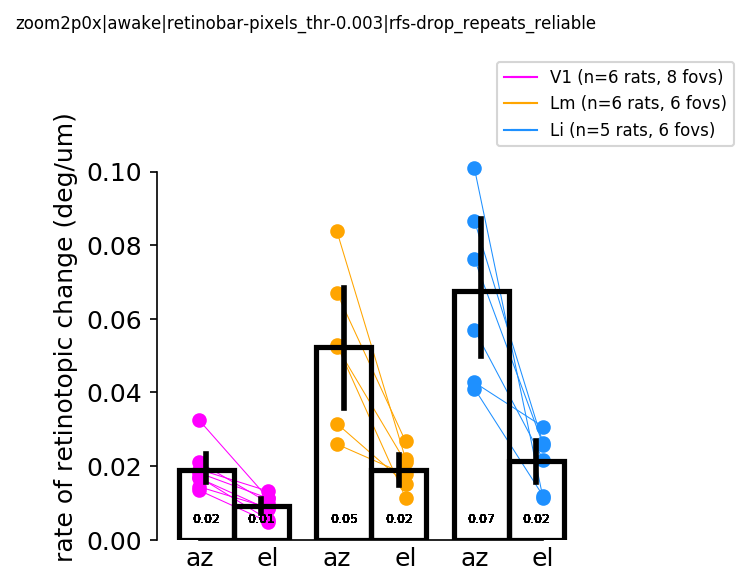

In [254]:
#metric = 'cortical_mag'
metric = 'abs_coef'

fig = plot_pairwise_by_axis(projdf_filtered, curr_metric=metric, c1='az', c2='el',
                           area_colors=area_colors, fontsize=6, fontcolor='k')
pl.subplots_adjust(left=0.2, right=0.75, top=0.8)
if metric=='cortical_mag':
    pl.ylabel('cortical magnification (um/deg)', fontsize=12)
    pl.ylim([0, 220])
elif metric=='abs_coef':
    pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)
    pl.ylim([0, 0.11])
    
sns.despine(trim=True)
label_figure(fig, data_id)
figname = '%s_paired_retino-R2-%.2f-%s__%s' % (metric, retino_r2, retino_pass_crit, figstr)
pl.savefig(os.path.join(gradient_dir, '%s.svg' % figname))
print(gradient_dir, figname)

## Drop Repeats - any (not paired)

In [367]:
projdf_either = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) or (g[g['cond']=='el']['R2'].values > r2_thr))])

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis', 'cortical_mag_any__rfs_drop_repeats_retino_pixels_thr-0.003')


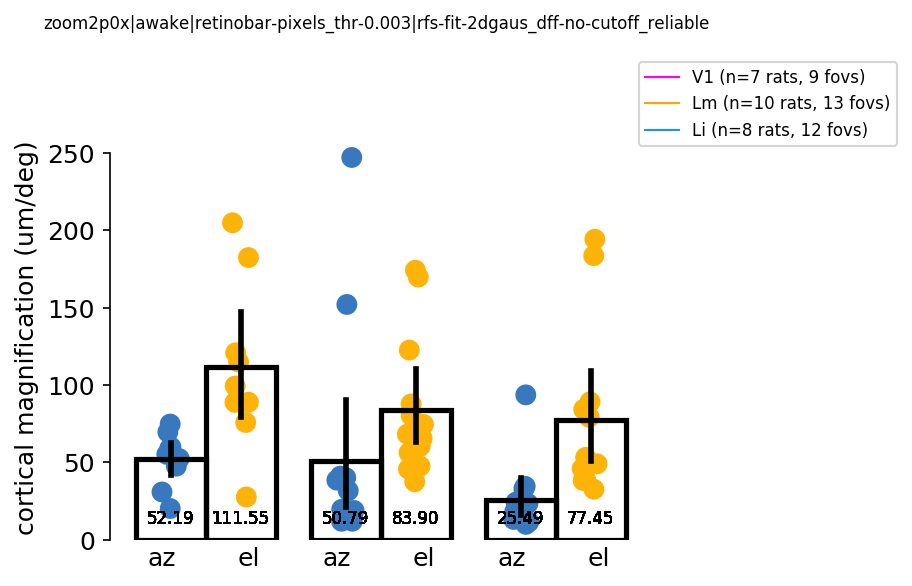

In [371]:
plotdf = projdf_either.copy()

metric='cortical_mag'
hue='cond'
currcols = ['windows blue', 'amber']
fig = plot_axis_distributions(plotdf, currmetric=metric, hue=hue,
                            currcols=currcols, area_colors=area_colors,
                             fontsize=8, fontcolor='k')
pl.subplots_adjust(left=0.1, right=0.8, top=0.8)
if metric=='cortical_mag':
    pl.ylabel('cortical magnification (um/deg)', fontsize=12)
elif metric=='abs_coef':
    pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)

label_figure(fig, data_id)
figname = '%s_any__%s' % (metric, figstr)
pl.savefig(os.path.join(gradient_dir, '%s.svg' % figname))
print(gradient_dir, figname)


# Get projected ctx positions

In [255]:
rfdf['ml_proj'] = ''
rfdf['ap_proj'] = ''
n_dsets = len(rfdf.groupby(['datakey', 'experiment']).groups)

for di, ((datakey, exp), rd) in enumerate(rfdf.groupby(['datakey', 'experiment'])):
    if di % 10 == 0 or di==(n_dsets-1):
        print("%i of %i gradient result files loaded." % (int(di+1), n_dsets))
        
    retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
    fpath = p_df['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % magthr_str)
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Project FOV coordinates
    rfdf['ml_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])
    rfdf['ap_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])

1 of 41 gradient result files loaded.
11 of 41 gradient result files loaded.
21 of 41 gradient result files loaded.
31 of 41 gradient result files loaded.
41 of 41 gradient result files loaded.


In [256]:
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
# projdf.groupby(['visual_area', 'datakey', 'cond']).mean()

             datakey
visual_area         
Li                13
Lm                13
V1                 9


In [257]:
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


             datakey
visual_area         
Li                13
Lm                13
V1                 9


## Plot az/el per session, for 1 FOV (rfs or rfs10, best retino)

In [258]:
def plot_retino_scatter_by_fov(vdf, projdf, cond_colors=['blue', 'orange'], cond_names=['az', 'el'],
                            markersize=10, col_wrap=6):
    n_fovs = len(vdf['datakey'].unique())
    n_subplots = n_fovs*2
    n_rows = int(np.ceil(n_subplots/float(col_wrap))) #nsubplots % col_wrap

    fig, axn = pl.subplots(n_rows, col_wrap, figsize=(col_wrap*3, n_rows*4))
    ai=0
    for datakey, rfs_ in vdf.groupby(['datakey']):
        for ci, (col, cond) in enumerate(zip(cond_colors, cond_names)):
            ax = axn.flat[ai]
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'

            # Get RF fit info
            cell_locs = rfs_['%s_pos' % xname].values
            proj_locs = rfs_['%s_proj' % xname].values
            rf_locs = rfs_[yname].values

            # Plot RF pos
            ax.scatter(cell_locs, rf_locs, marker='o', s=markersize, color='k')

            # Plot projected
            ax.scatter(proj_locs, rf_locs, marker='o', s=markersize, color=col)

            # Plot retino direction
            # Get best retino run, in case there is > 1
            retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
            ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()

            slope = float(ret_[ret_['cond']==cond]['coefficient'])
            intercept = float(ret_[ret_['cond']==cond]['intercept'])
            ls = ':' if float(ret_[ret_['cond']==cond]['R2']) < r2_thr else '-'
            r2_v = float(ret_[ret_['cond']==cond]['R2'])
            label_prefix = '%s, R2=%.2f' % (cond, r2_v) #(retinorun.split('_')[-1], r2_v)
            # label = len(regdf_vs)>2
            ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix, ls=ls)
            if ci==0:
                ax.set_title(datakey, fontsize=20, loc='left')
            ai += 1
            ax.legend(loc='bottom') #bbox_to_anchor=(0.5, -0.1))
            
    for a in np.arange(ai, (n_rows*col_wrap)):
        axn.flat[a].axis('off')
        
    return fig


In [259]:

by_session_dir = os.path.join(dst_dir, 'scatter_by_session_%s' % rf_filter_by)
if not os.path.exists(by_session_dir):
    os.makedirs(by_session_dir)

print(data_id)

zoom2p0x|awake|retinobar-pixels_thr-0.003|rfs-drop_repeats_reliable


In [260]:
by_session_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session_drop_repeats'

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session_drop_repeats', 'rfs_Li_retinoscatter_rfs_drop_repeats_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session_drop_repeats', 'rfs_Lm_retinoscatter_rfs_drop_repeats_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session_drop_repeats', 'rfs_V1_retinoscatter_rfs_drop_repeats_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session_drop_repeats', 'rfs10_Li_retinoscatter_rfs_drop_repeats_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/scatter_by_session_drop_repeats', 'rfs10_Lm_retinoscatter_rfs_drop_repeats_retino_pixels_thr-0.003')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinoto

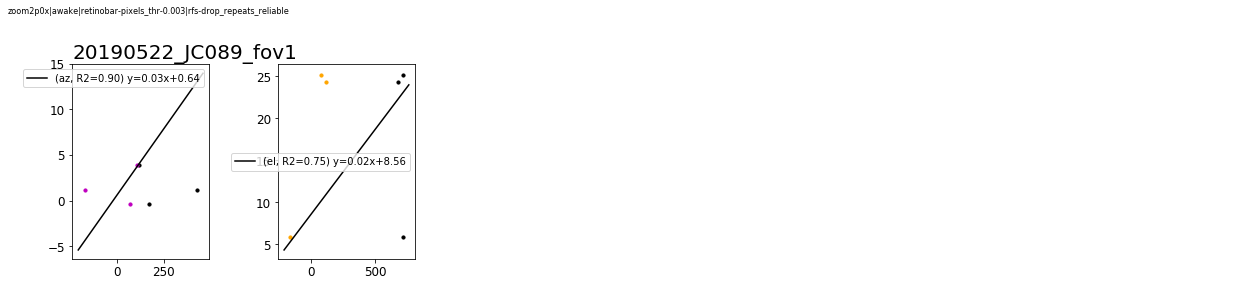

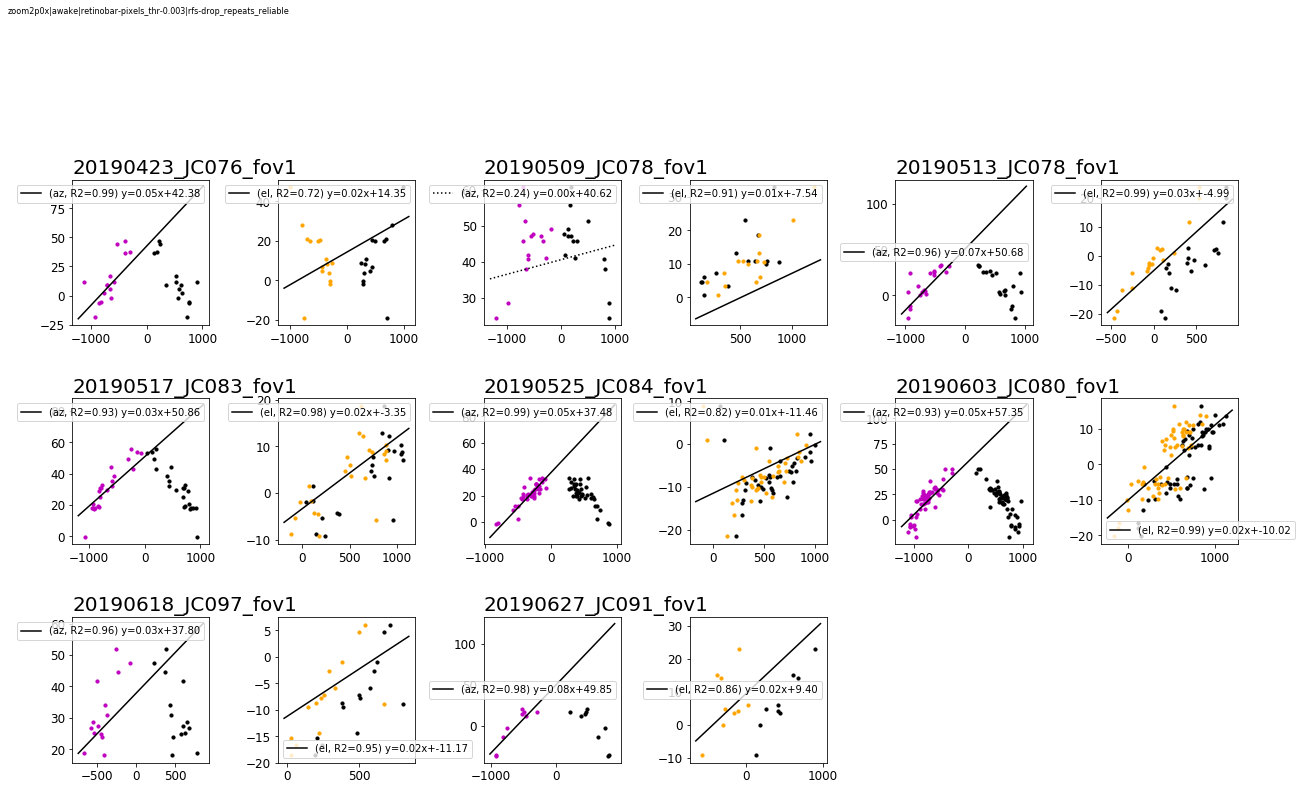

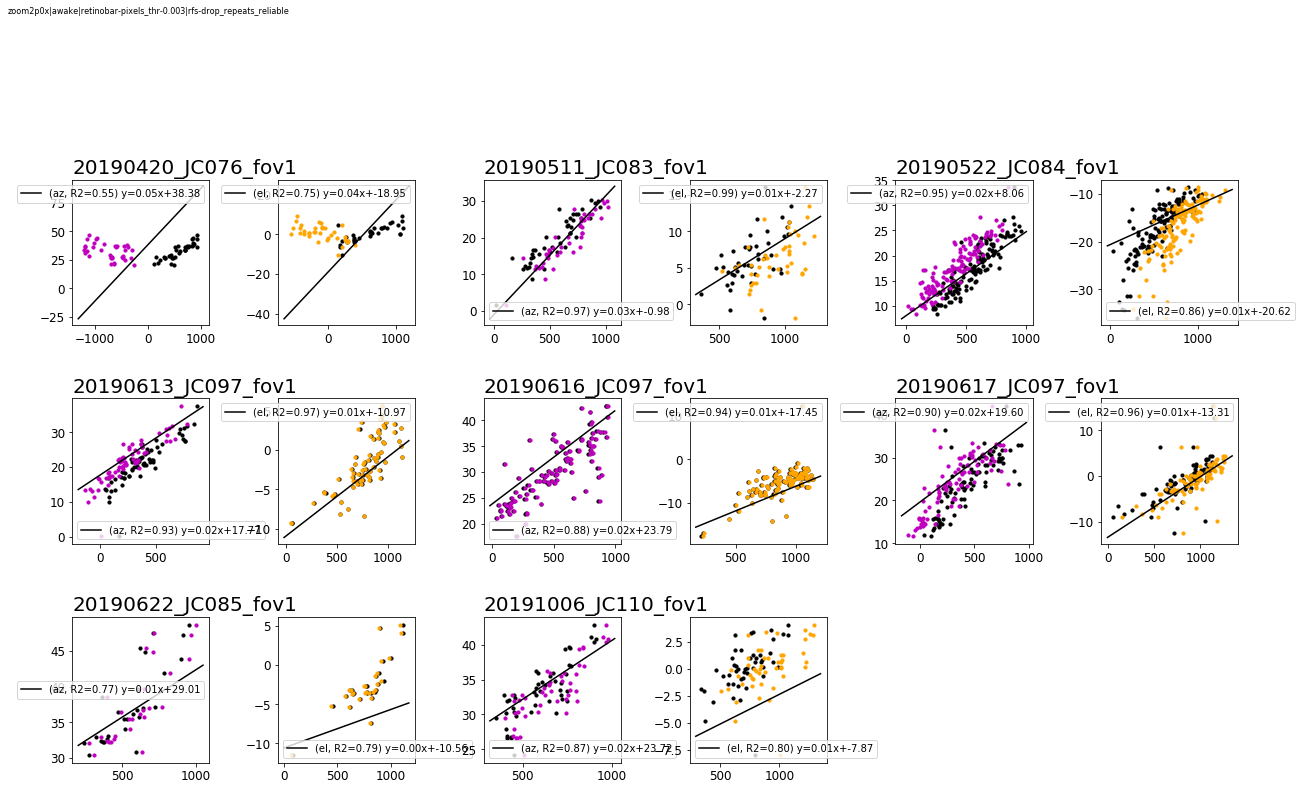

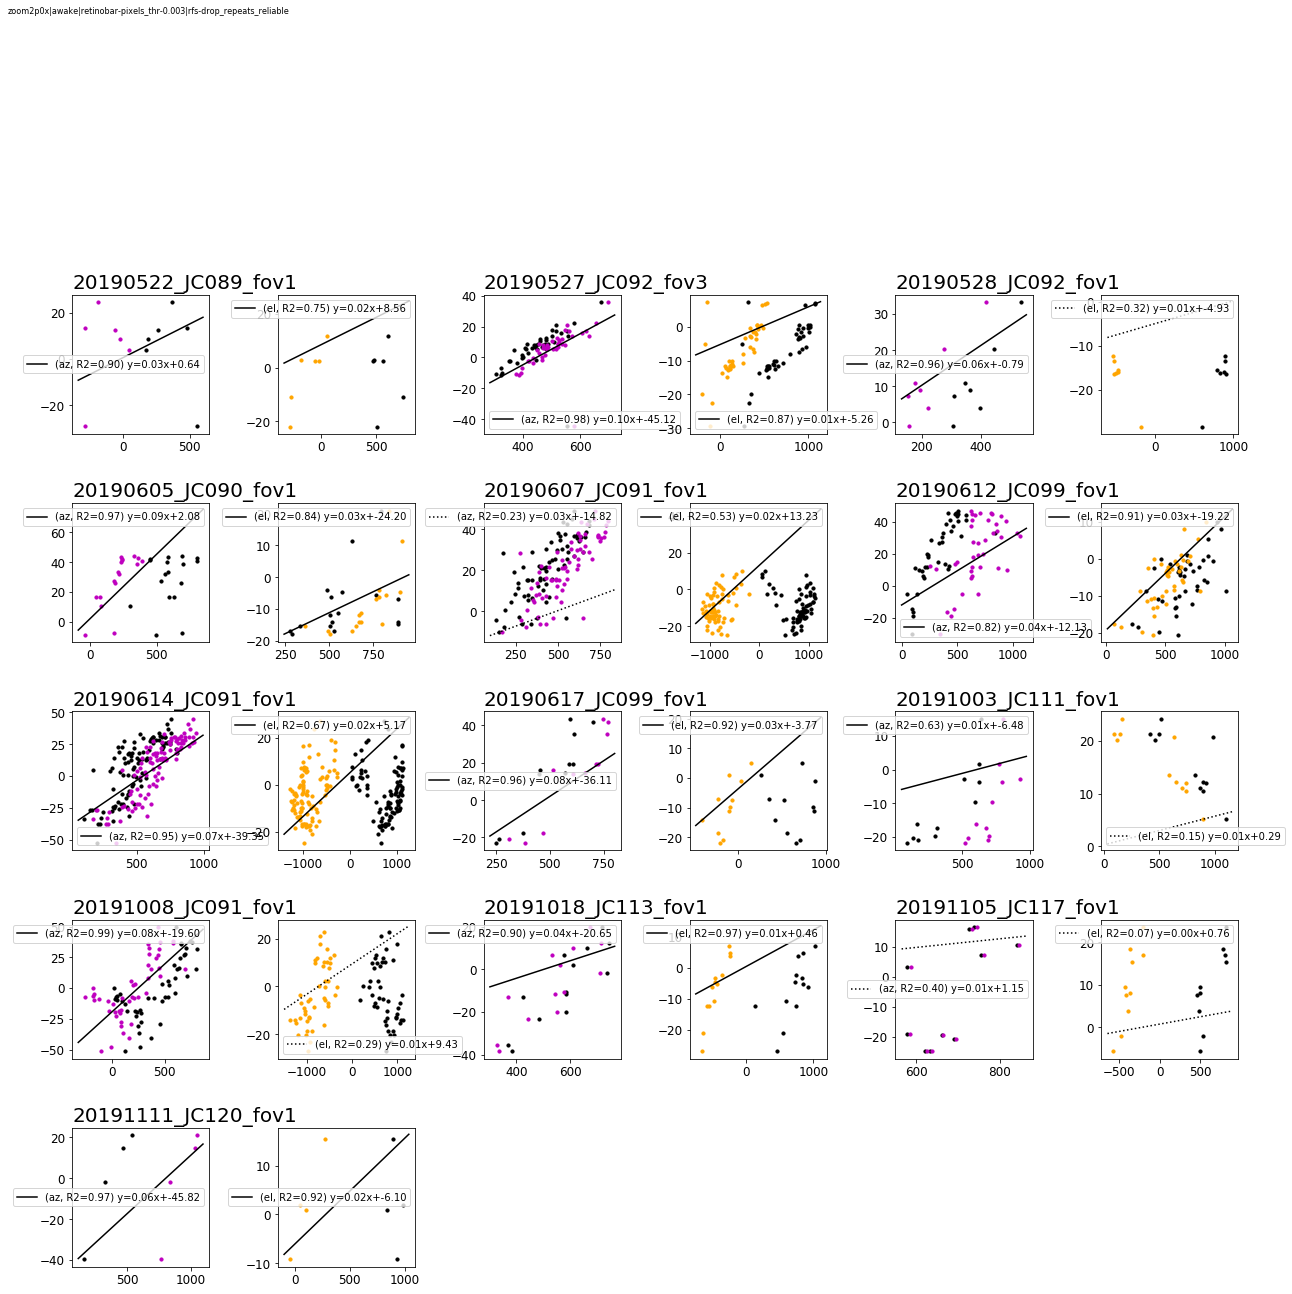

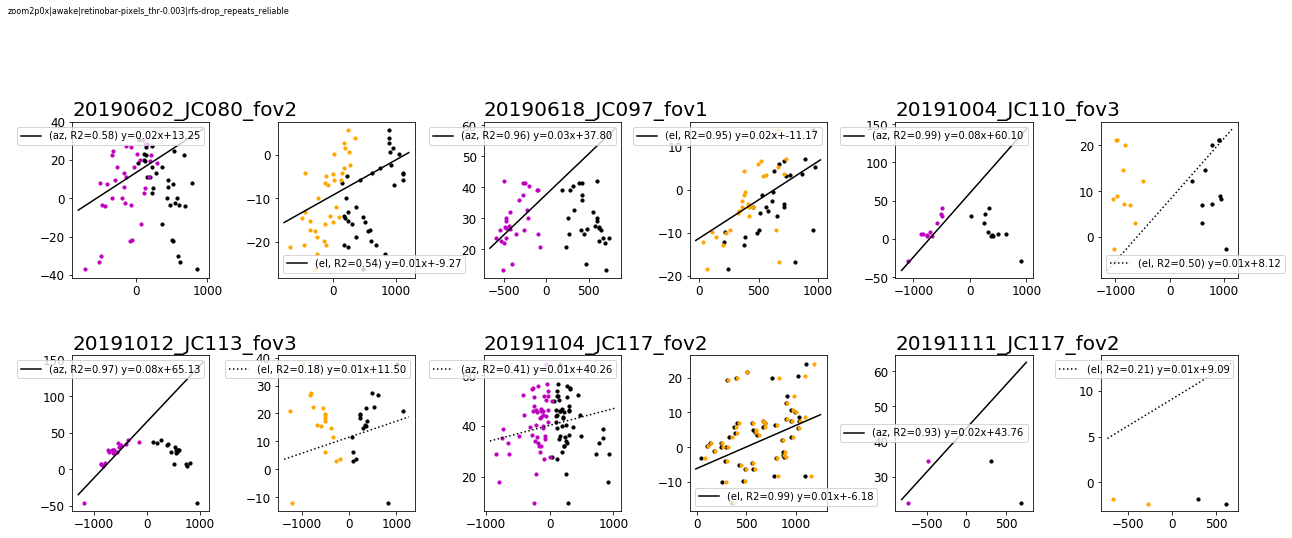

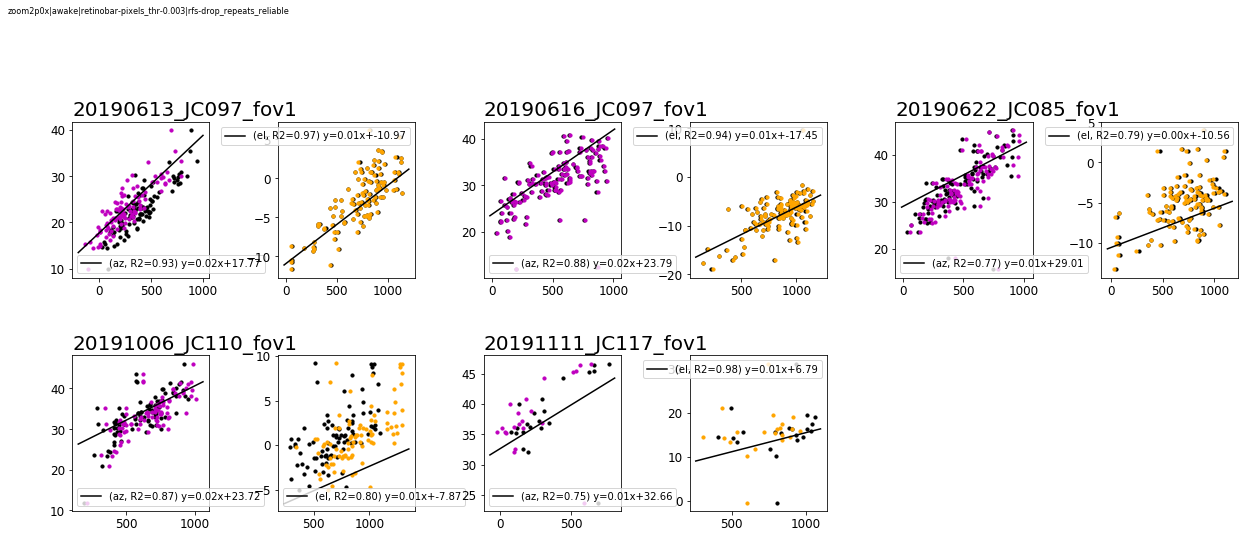

In [261]:
col_wrap = 6
cond_names = ['az', 'el']
cond_colors = ['m', 'orange']
markersize = 10

for rfname, rfdf_exp in rfdf.groupby(['experiment']):
    for visual_area, rfdf_vis in rfdf_exp.groupby(['visual_area']): #['V1', 'Lm', 'Li']:

        curr_fig_title = '%s: RFS (%s), Retino (magthr-%.3f)' % (visual_area, rfname, mag_thr)

        fig = plot_retino_scatter_by_fov(rfdf_vis, projdf, cond_colors=cond_colors, cond_names=cond_names,
                                    markersize=markersize, col_wrap=col_wrap)

        label_figure(fig, data_id)   
        pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.05, right=0.95)

        figname = '%s_%s_retinoscatter_%s' % (rfname, visual_area, figstr) 
        pl.savefig(os.path.join(by_session_dir, '%s.svg' % figname))

        print(by_session_dir, figname)

In [74]:
print(by_session_dir, figname)

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/scatter_by_session', 'compare_runs_retinograd_pixels_thr-0.003')


# Aggregate scatter metrics

In [262]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)



In [263]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

# scatdf:  filter gradient results, only include if good fits

In [268]:
#rfname = 'rfs10'
retino_r2=0.75
min_ncells=5
retino_pass_crit='both' 

if retino_pass_crit=='both':
    filtproj = pd.concat([g for k, g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
                            if ((g[g['cond']=='az']['R2'].values>retino_r2) and (g[g['cond']=='el']['R2'].values>retino_r2))])
else:
    filtproj = pd.concat([g for k, g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
                            if ((g[g['cond']=='az']['R2'].values>retino_r2) or (g[g['cond']=='el']['R2'].values>retino_r2))])

#curr_gradients = projdf[projdf['R2']>=retino_r2].copy()
curr_gradients = filtproj.copy()


#curr_rfs = rfdf[rfdf['experiment']==rfname].copy()

not_enough_cells_fit = []
bad_fits = []
d_list = []
for (visual_area, datakey, rfname), rfs_ in rfdf.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:
    if rfs_.shape[0] < min_ncells:
        print("--- too few cells (min%i), %s" % (min_ncells, datakey))
        not_enough_cells_fit.append(datakey)
        continue
    if datakey not in curr_gradients['datakey'].unique():
        print("---bad gradient, %s" % datakey)
        continue

    # Get retino gradient
    #retinorun = curr_gradients[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    #ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()
    ret_ = curr_gradients[curr_gradients['datakey']==datakey].copy()
    
    for cond, ret_cond in ret_.groupby(['cond']):
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'
        max_degrees = screen['azimuth_deg'] if cond=='az' else screen['altitude_deg']
        max_fovdist = 1177 if cond=='ap' else 972.
        
        # Get RF fit info
        proj_locs = np.array(rfs_['%s_proj' % xname].values)
        rf_locs = np.array(rfs_[yname].values)

        # Get dist to line:
        slope = float(ret_cond['coefficient'])
        intercept = float(ret_cond['intercept'])
        r2 = float(ret_cond['R2'])
        predicted_rf_locs = slope*proj_locs + intercept

        deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
        deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees]
        dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
        dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist]
        keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
        n_pts = len(keep_ixs)
        if (n_pts)==0:
            bad_fits.append((datakey, cond))
            continue
            
        if any(np.isnan(dist_sc)):
            print(visual_area, datakey, r2)
        if any(np.isnan(deg_sc)):
            print(visual_area, datakey, r2)
        tmpd=pd.DataFrame({'deg_scatter': deg_sc[keep_ixs],
                           'dist_scatter': dist_sc[keep_ixs],
                           'measured_rf': rf_locs[keep_ixs],
                           'predicted_rf': predicted_rf_locs[keep_ixs],
                           'measured_loc': proj_locs[keep_ixs],
                           'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                           'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                           'axis': [cond for _ in np.arange(0, n_pts)],
                           'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                           'datakey': [datakey for _ in np.arange(0, n_pts)],
                           'rfname': [rfname for _ in np.arange(0, n_pts)]
                     })
        d_list.append(tmpd)
scatdf = pd.concat(d_list, axis=0)
print(scatdf.shape)
scatdf.head()


--- too few cells (min5), 20190522_JC089_fov1
---bad gradient, 20190522_JC089_fov1
---bad gradient, 20190528_JC092_fov1
---bad gradient, 20190607_JC091_fov1
---bad gradient, 20190614_JC091_fov1
---bad gradient, 20191003_JC111_fov1
---bad gradient, 20191008_JC091_fov1
---bad gradient, 20191105_JC117_fov1
--- too few cells (min5), 20191111_JC120_fov1
---bad gradient, 20190423_JC076_fov1
---bad gradient, 20190509_JC078_fov1
---bad gradient, 20190602_JC080_fov2
---bad gradient, 20191004_JC110_fov3
---bad gradient, 20191012_JC113_fov3
---bad gradient, 20191104_JC117_fov2
--- too few cells (min5), 20191111_JC117_fov2
---bad gradient, 20190420_JC076_fov1
(2479, 11)


axis              datakey  deg_scatter  dist_scatter measured_loc  \
0   az  20190527_JC092_fov3     4.481396     44.398004      629.847   
1   az  20190527_JC092_fov3     1.363426     13.507706      652.465   
2   az  20190527_JC092_fov3     0.637502      6.315845       620.84   
3   az  20190527_JC092_fov3     0.342061      3.388857      605.702   
4   az  20190527_JC092_fov3     1.941626     19.236043      545.999   

   measured_rf  predicted_loc predicted_rf  retino_R2 rfname visual_area  
0    13.970935     585.448948      18.4523   0.979097  rfs10          Li  
1    22.098769     665.972884      20.7353   0.979097  rfs10          Li  
2    16.905663     614.523837      17.5432   0.979097  rfs10          Li  
3    15.673189     602.313491      16.0152   0.979097  rfs10          Li  
4     8.047331     526.762728      9.98896   0.979097  rfs10          Li

In [270]:
print("Not enough cells passed RF fit:", not_enough_cells_fit)
print("Bad fits for predicted pos/rf:", bad_fits)

('Not enough cells passed RF fit:', ['20190522_JC089_fov1', '20191111_JC120_fov1', '20191111_JC117_fov2'])
('Bad fits for predicted pos/rf:', [])


0.75


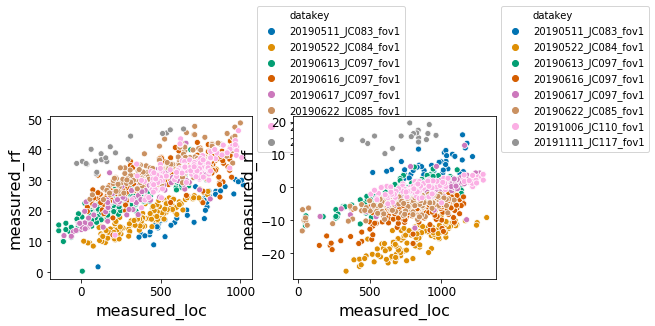

In [271]:
print(retino_r2)
plotdf = scatdf[scatdf['retino_R2']>retino_r2].copy()
sns.set_palette('colorblind')
fig, axn = pl.subplots(1,2, figsize=(8,3))
visual_area = 'V1'

vdf = plotdf[plotdf['visual_area']==visual_area]

for ax, (cond, vdf_ax) in zip(axn.flat, vdf.groupby(['axis'])):

    sns.scatterplot(x='measured_loc', y='measured_rf', data=vdf_ax, ax=ax,
                    hue='datakey')
    
    ax.legend(bbox_to_anchor=(1., 1.7))

In [272]:
scatdf['retino_R2'].min()

0.75145100173045687

In [273]:
#retino_thr = 0.9
#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

mean_scatter = scatdf.groupby(['visual_area', 'datakey', 'axis', 'rfname']).mean().reset_index()
mean_scatter.head()

print(mean_scatter.shape)
#print(mean_values[mean_values['retino_R2']>0.9].shape)
#mean_scatter

(48, 9)


In [274]:
print(retino_r2)

0.75


In [275]:
from matplotlib.lines import Line2D

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'aggr_scatter_avg-fovs_hue-RFvRF10_retino-grad-R2-0.75-both__rfs_drop_repeats_retino_pixels_thr-0.003')


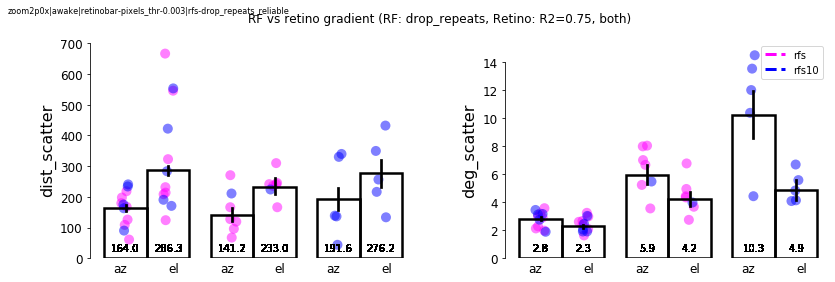

In [276]:
plot_cells=False
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

plot_str = '' if plot_cells else 'fovmeans'

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
    #if barplot:
    sns.barplot("visual_area", plotter, data=scatdf, ax=ax,
               hue='axis', order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs'], 
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[0], 'az': rfcolors[0]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
    
    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs10'], 
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
    ax.legend_.remove()

    scatdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
    #scatdf[scatdf['rfname']=='rfs'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='m')
    #scatdf[scatdf['rfname']=='rfs10'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='c')

    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
    #ax.legend_.remove()


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in rfcolors]
ax.legend(lines, rfnames)


sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  
fig.suptitle('RF vs retino gradient (RF: %s, Retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2, retino_pass_crit))


figname = 'aggr_scatter_avg-fovs_hue-RFvRF10_retino-grad-R2-%.2f-%s__%s' % (retino_r2, retino_pass_crit, figstr )
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [146]:
plot_cells=False
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']


('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels', 'deg-dist-scatter_RFvRF10_retino-R2-0.75-both__rfs_drop_repeats_retino_pixels_thr-0.003')


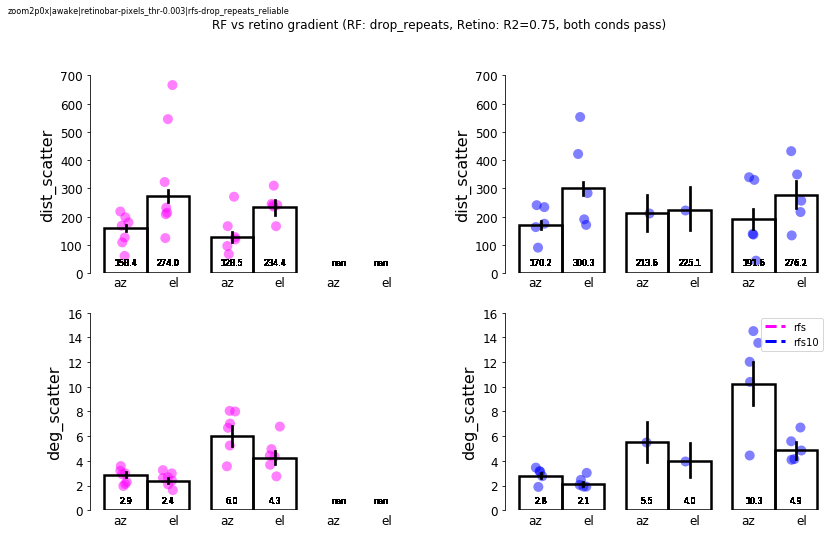

In [277]:

fig, axn = pl.subplots(2,2, figsize=(12,8))
for ai, plotter in enumerate( ['dist_scatter', 'deg_scatter']):
    for ci, (currcolor, currname) in enumerate(zip(rfcolors, rfnames)):
        ax = axn[ai, ci]
        
        axdf = scatdf[scatdf['rfname']==currname].copy()
        meandf = axdf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

        sns.barplot("visual_area", plotter, data=axdf, ax=ax,
                   hue='axis', order=visual_areas, errcolor="k",
                   edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
        change_width(ax, .4)

        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=meandf, #mean_scatter[mean_scatter['rfname']==currname], 
                      dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                     palette={'el': currcolor, 'az': currcolor}, alpha=0.5, order=['V1', 'Lm', 'Li'])
        ax.legend_.remove()
        axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f')
        rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
        if ai==0:
            ax.set_ylim([0, 700])
        else:
            ax.set_ylim([0, 16])

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in rfcolors]
ax.legend(lines, rfnames)

sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
fig.suptitle('RF vs retino gradient (RF: %s, Retino: R2=%.2f, %s conds pass)' % (rf_filter_by, retino_r2, retino_pass_crit))


label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  


figname = 'deg-dist-scatter_RFvRF10_retino-R2-%.2f-%s__%s' % (retino_r2, retino_pass_crit, figstr )
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### Plot for RFs 

deg-dist-scatter_rfs_all-fovs_retino-R2-0.75-both


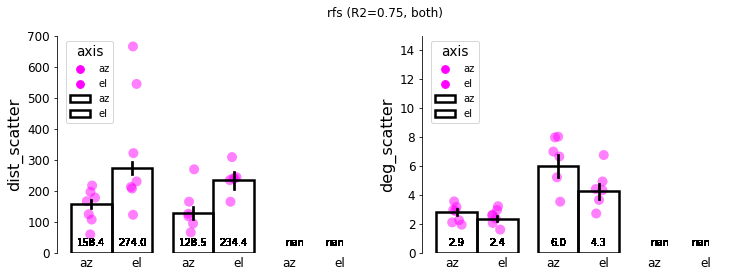

In [278]:
rfname = rfnames[0]
plotdf = scatdf[scatdf['rfname']==rfname]
meandf = plotdf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
    #if barplot:
    sns.barplot("visual_area", plotter, hue='axis', data=plotdf, ax=ax,
               order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=meandf,
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[0], 'az': rfcolors[0]}, alpha=0.5, order=['V1', 'Lm', 'Li'])

    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
    #ax.legend_.remove()
    
axn[0].set_ylim([0, 700])
axn[1].set_ylim([0, 15])

pl.suptitle('%s (R2=%.2f, %s)'  % (rfname, retino_r2, retino_pass_crit))
figname = 'deg-dist-scatter_%s_%s__retino-R2-%.2f-%s' % (rfname, rf_filter_by, retino_r2, retino_pass_crit)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

#### Plot for RFs10

deg-dist-scatter_rfs10_drop_repeats__retino-R2-0.75-both


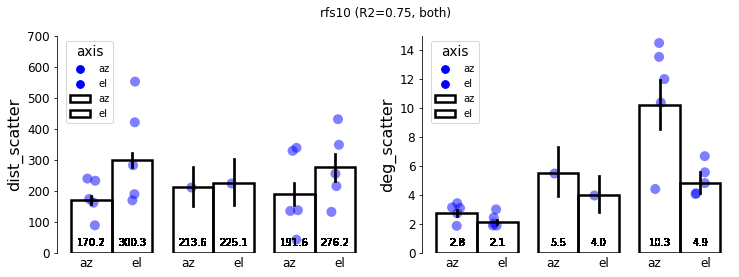

In [279]:
rfname = rfnames[1]
plotdf = scatdf[scatdf['rfname']==rfname]
meandf = plotdf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
    #if barplot:
    sns.barplot("visual_area", plotter, hue='axis', data=plotdf, ax=ax,
               order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=meandf,
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])

    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

axn[0].set_ylim([0, 700])
axn[1].set_ylim([0, 15])

pl.suptitle(rfname)
pl.suptitle('%s (R2=%.2f, %s)'  % (rfname, retino_r2, retino_pass_crit))
figname = 'deg-dist-scatter_%s_%s__retino-R2-%.2f-%s' % (rfname, rf_filter_by, retino_r2, retino_pass_crit)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [280]:
bothrfs = pd.concat([g for v, g in scatdf.groupby(['visual_area', 'datakey']) \
                             if 'rfs' in g['rfname'].values and 'rfs10' in g['rfname'].values])
bothrfs.shape


(1400, 11)

In [281]:
meanboth = bothrfs.groupby(['visual_area', 'datakey', 'rfname', 'axis']).mean().reset_index().sort_values(by='datakey')

meanboth['animalid'] = [s.split('_')[1] for s in meanboth['datakey']]
meanboth['session'] = [s.split('_')[0] for s in meanboth['datakey']]
meanboth['fov'] = [s.split('_')[2] for s in meanboth['datakey']]


In [282]:
meanboth

visual_area              datakey rfname axis  deg_scatter  dist_scatter  \
4           V1  20190613_JC097_fov1    rfs   az     2.284635    108.707695   
5           V1  20190613_JC097_fov1    rfs   el     2.096008    208.400985   
6           V1  20190613_JC097_fov1  rfs10   az     1.894361     90.137643   
7           V1  20190613_JC097_fov1  rfs10   el     1.914386    190.342774   
9           V1  20190616_JC097_fov1    rfs   el     2.401976    213.660558   
11          V1  20190616_JC097_fov1  rfs10   el     1.917581    170.572700   
10          V1  20190616_JC097_fov1  rfs10   az     3.166921    174.852600   
8           V1  20190616_JC097_fov1    rfs   az     3.580395    197.681435   
0           Lm  20190618_JC097_fov1    rfs   az     7.017212    270.376137   
2           Lm  20190618_JC097_fov1  rfs10   az     5.544424    213.628984   
1           Lm  20190618_JC097_fov1    rfs   el     4.349254    244.987641   
3           Lm  20190618_JC097_fov1  rfs10   el     3.996721    225.129915   
12          V1  20190622_JC085_fov1    rfs   az     2.916560    218.172282   
13          V1  20190622_JC085_fov1    rfs   el     3.248817    665.955597   
14          V1  20190622_JC085_fov1  rfs10   az     3.124018    233.691161   
15          V1  20190622_JC085_fov1  rfs10   el     2.057497    421.753902   
18          V1  20191006_JC110_fov1  rfs10   az     2.759607    162.839711   
16          V1  20191006_JC110_fov1    rfs   az     2.133275    125.880957   
17          V1  20191006_JC110_fov1    rfs   el     2.987850    545.257001   
19          V1  20191006_JC110_fov1  rfs10   el     3.029004    552.767252   

    measured_rf  predicted_loc  retino_R2 animalid   session   fov  
4     21.505552     177.767102   0.929008    JC097  20190613  fov1  
5     -1.696596     921.960363   0.966632    JC097  20190613  fov1  
6     22.868336     242.611174   0.929008    JC097  20190613  fov1  
7     -2.717231     820.481140   0.966632    JC097  20190613  fov1  
9     -5.698412    1045.325373   0.936202    JC097  20190616  fov1  
11    -7.819567     856.644361   0.936202    JC097  20190616  fov1  
10    31.167543     407.188630   0.878668    JC097  20190616  fov1  
8     30.267266     357.482412   0.878668    JC097  20190616  fov1  
0     31.721507    -234.253751   0.955981    JC097  20190618  fov1  
2     29.404789    -323.517866   0.955981    JC097  20190618  fov1  
1     -7.523624     205.419079   0.954744    JC097  20190618  fov1  
3     -2.740422     474.850443   0.954744    JC097  20190618  fov1  
12    37.446072     630.921303   0.767999    JC085  20190622  fov1  
13    -4.142326    1316.157129   0.787985    JC085  20190622  fov1  
14    33.622544     344.903568   0.767999    JC085  20190622  fov1  
15    -5.862170     963.616596   0.787985    JC085  20190622  fov1  
18    33.453957     574.484197   0.869042    JC110  20191006  fov1  
16    33.398244     571.196679   0.869042    JC110  20191006  fov1  
17     0.049870    1444.574256   0.804285    JC110  20191006  fov1  
19    -0.144574    1409.089957   0.804285    JC110  20191006  fov1

In [283]:
bothrfs.groupby(['visual_area', 'datakey', 'rfname']).count()

axis  deg_scatter  dist_scatter  \
visual_area datakey             rfname                                    
Lm          20190618_JC097_fov1 rfs       28           28            28   
                                rfs10     55           55            55   
V1          20190613_JC097_fov1 rfs      134          134           134   
                                rfs10    214          214           214   
            20190616_JC097_fov1 rfs      203          203           203   
                                rfs10    260          260           260   
            20190622_JC085_fov1 rfs       47           47            47   
                                rfs10    214          214           214   
            20191006_JC110_fov1 rfs       92           92            92   
                                rfs10    153          153           153   

                                        measured_loc  measured_rf  \
visual_area datakey             rfname                              
Lm          20190618_JC097_fov1 rfs               28           28   
                                rfs10             55           55   
V1          20190613_JC097_fov1 rfs              134          134   
                                rfs10            214          214   
            20190616_JC097_fov1 rfs              203          203   
                                rfs10            260          260   
            20190622_JC085_fov1 rfs               47           47   
                                rfs10            214          214   
            20191006_JC110_fov1 rfs               92           92   
                                rfs10            153          153   

                                        predicted_loc  predicted_rf  retino_R2  
visual_area datakey             rfname                                          
Lm          20190618_JC097_fov1 rfs                28            28         28  
                                rfs10              55            55         55  
V1          20190613_JC097_fov1 rfs               134           134        134  
                                rfs10             214           214        214  
            20190616_JC097_fov1 rfs               203           203        203  
                                rfs10             260           260        260  
            20190622_JC085_fov1 rfs                47            47         47  
                                rfs10             214           214        214  
            20191006_JC110_fov1 rfs                92            92         92  
                                rfs10             153           153        153

V1: (t-stat:-0.03, p=0.98)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:-0.19, p=0.86)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:1.69, p=0.19)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:1.29, p=0.29)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)


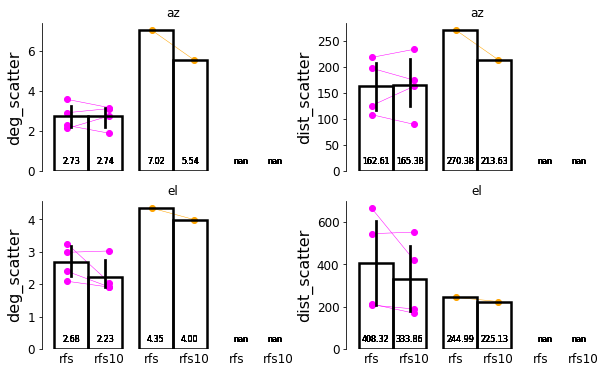

In [287]:
c1='rfs'
c2='rfs10'
# fig = plot_pairwise_by_axis(meanboth[meanboth['axis']=='az'], curr_metric='deg_scatter', compare_var='rfname',
#                             c1='rfs', c2='rfs10', legend=0, 
#                            area_colors=area_colors, fontsize=6, fontcolor='k')
fig, axn = pl.subplots(2,2, figsize=(10,6), sharex=True, sharey=False)
for ri, (axname, axdf) in enumerate(meanboth.groupby(['axis'])):
    ax = axn[ri, 0]
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(axdf, curr_metric='deg_scatter', ax=ax,
                                                c1=c1, c2=c2, compare_var='rfname')
    axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k')

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)
    ax.set_title(axname)
    
    
    ax = axn[ri, 1]
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(axdf, curr_metric='dist_scatter', ax=ax,
                                                c1=c1, c2=c2, compare_var='rfname')
    axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k')

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)
    ax.set_title(axname)

In [288]:
# retino_thr = 0.5
# plot_cells=False

# #plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

# plot_str = '' if plot_cells else 'fovmeans'

# fig, axn = pl.subplots(1,2, figsize=(12,4))
# for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
#     #if barplot:
#     sns.barplot("visual_area", plotter, data=scatdf, ax=ax,
#                hue='axis', order=visual_areas, errcolor="k",
#                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#     change_width(ax, .4)

    
#     if plot_cells:
#         sns.stripplot(x='visual_area', y=plotter, hue='axis', data=scatdf, 
#                       dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
#                       order=['V1', 'Lm', 'Li'])
#     else:
# #         sns.stripplot(x='visual_area', y=plotter, hue='rfname', data=mean_scatter, 
# #                       dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
# #                       order=['V1', 'Lm', 'Li'])
#         sns.stripplot(x='visual_area', y=plotter, hue='rfname', data=mean_scatter, 
#                       dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
#                       order=['V1', 'Lm', 'Li'])

#     scatdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f')
#     rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
#     #ax.legend_.remove()
    
# sns.despine(bottom=True, trim=True)
# ax.tick_params(which='both', axis='x', size=0)
# label_figure(fig, data_id)

# pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  

# figname = 'aggr_scatter_ALL_%s_retino-grad-R2-%.2f__%s' % (plot_str, retino_r2, figstr )
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

In [289]:
retino_r2

0.75

In [290]:
scatterfov_dir = os.path.join(dst_dir, 'example_scatter_fovs_%s' % rf_filter_by)
if not os.path.exists(scatterfov_dir):
    os.makedirs(scatterfov_dir)
print(scatterfov_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/pass_pixels/example_scatter_fovs_drop_repeats


((80, 11), (2, 18))
((34, 11), (2, 18))
((80, 11), (2, 18))
((22, 11), (2, 18))
((24, 11), (2, 18))
((38, 11), (2, 18))
((46, 11), (2, 18))
((73, 11), (2, 18))
((114, 11), (2, 18))
((28, 11), (2, 18))
((55, 11), (2, 18))
((18, 11), (2, 18))
((87, 11), (2, 18))
((248, 11), (2, 18))
((134, 11), (2, 18))
((214, 11), (2, 18))
((203, 11), (2, 18))
((260, 11), (2, 18))
((177, 11), (2, 18))
((47, 11), (2, 18))
((214, 11), (2, 18))
((92, 11), (2, 18))
((153, 11), (2, 18))
((38, 11), (2, 18))


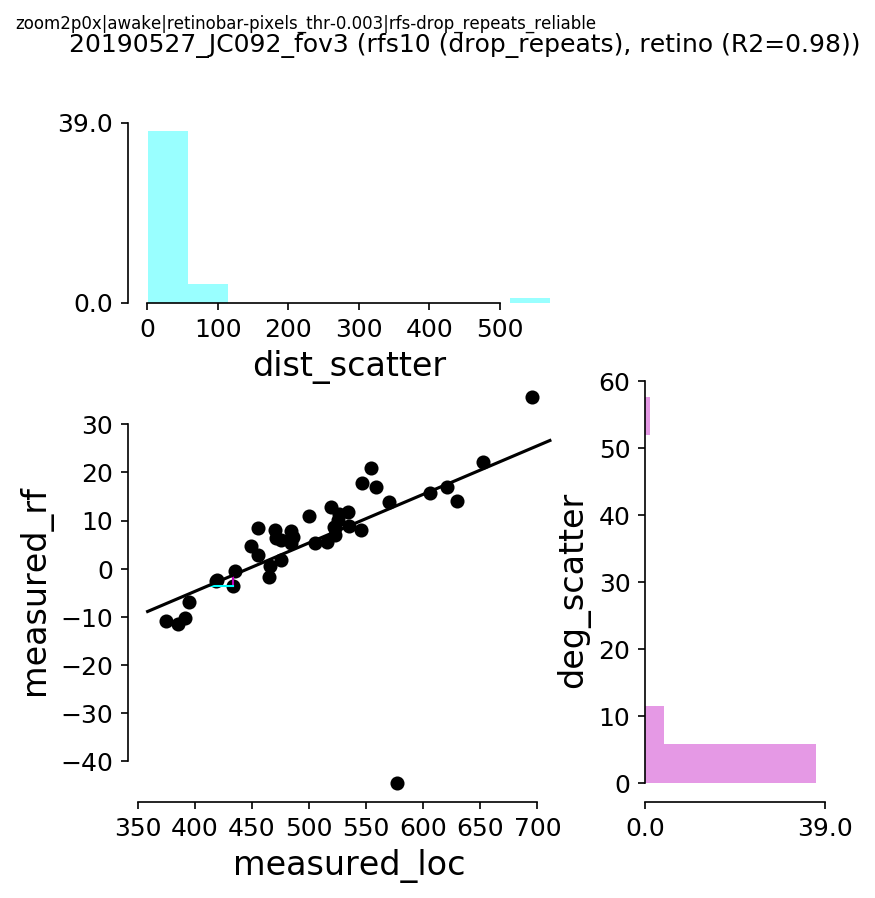

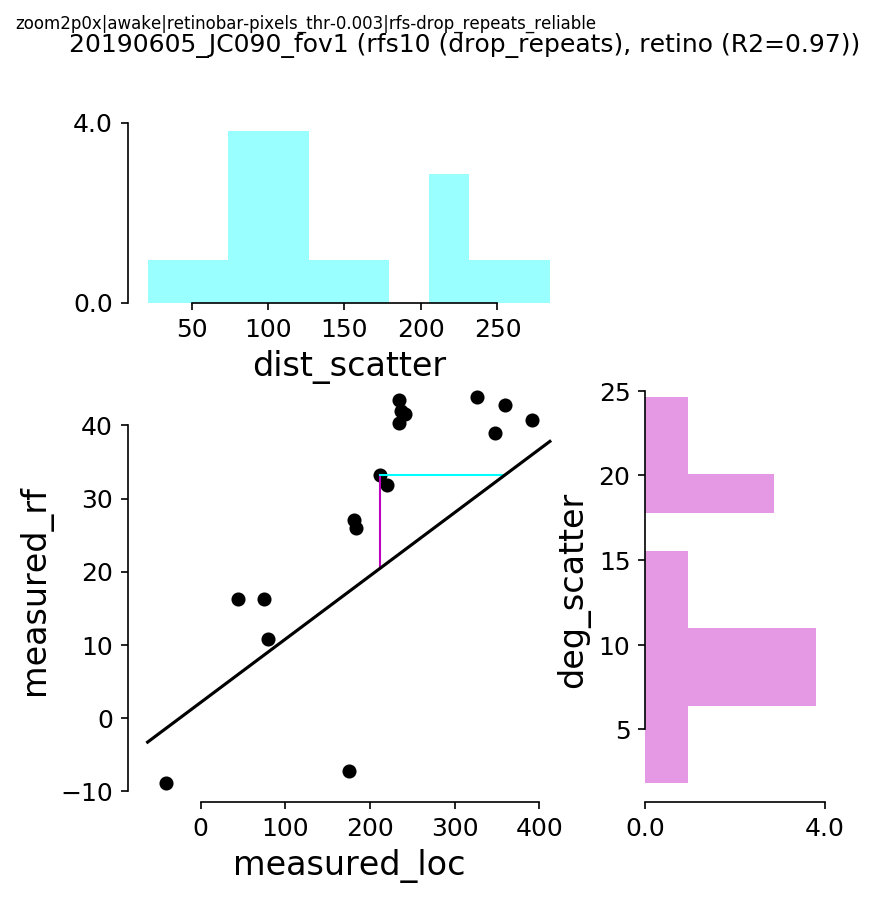

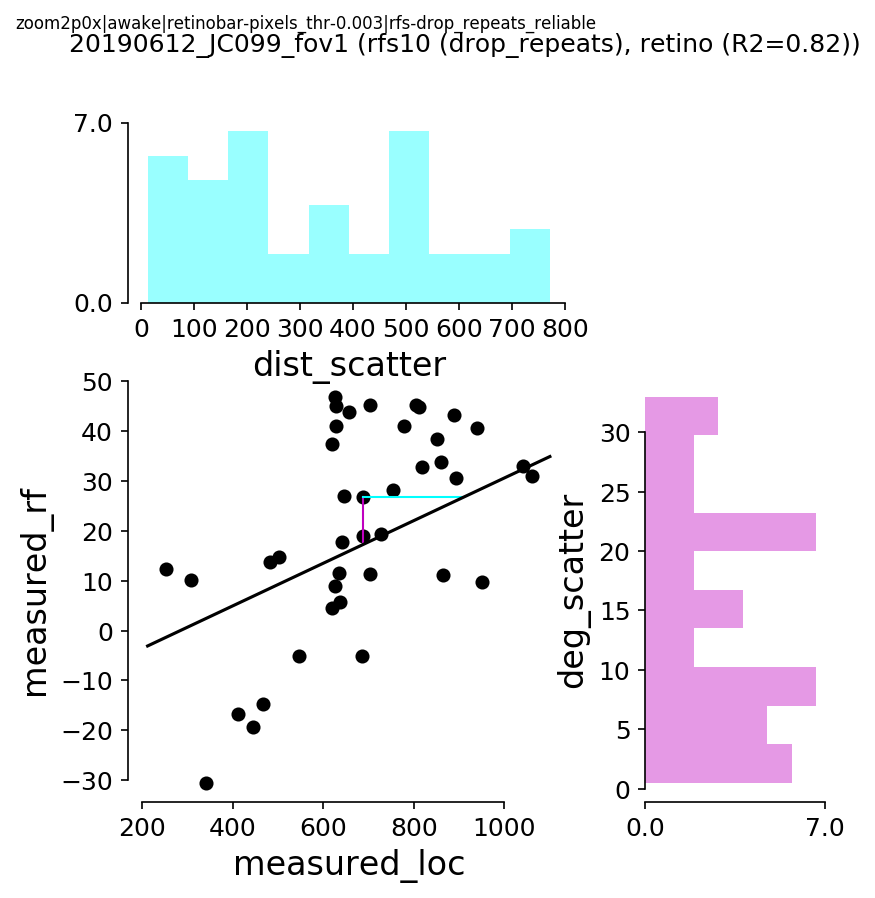

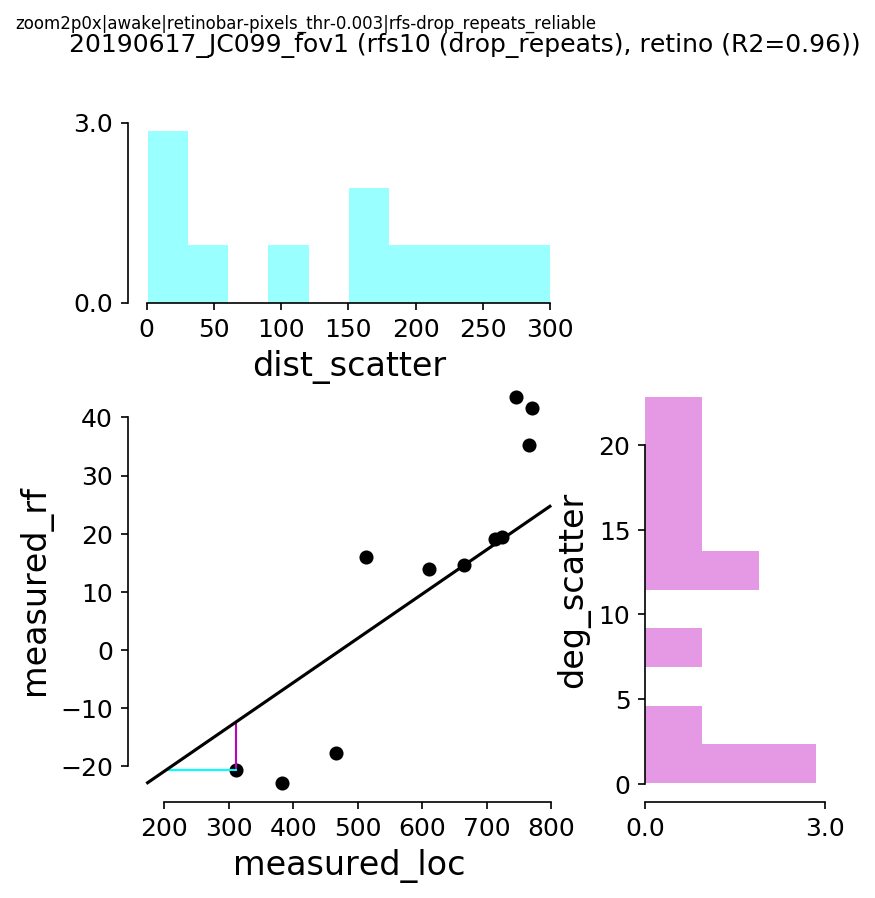

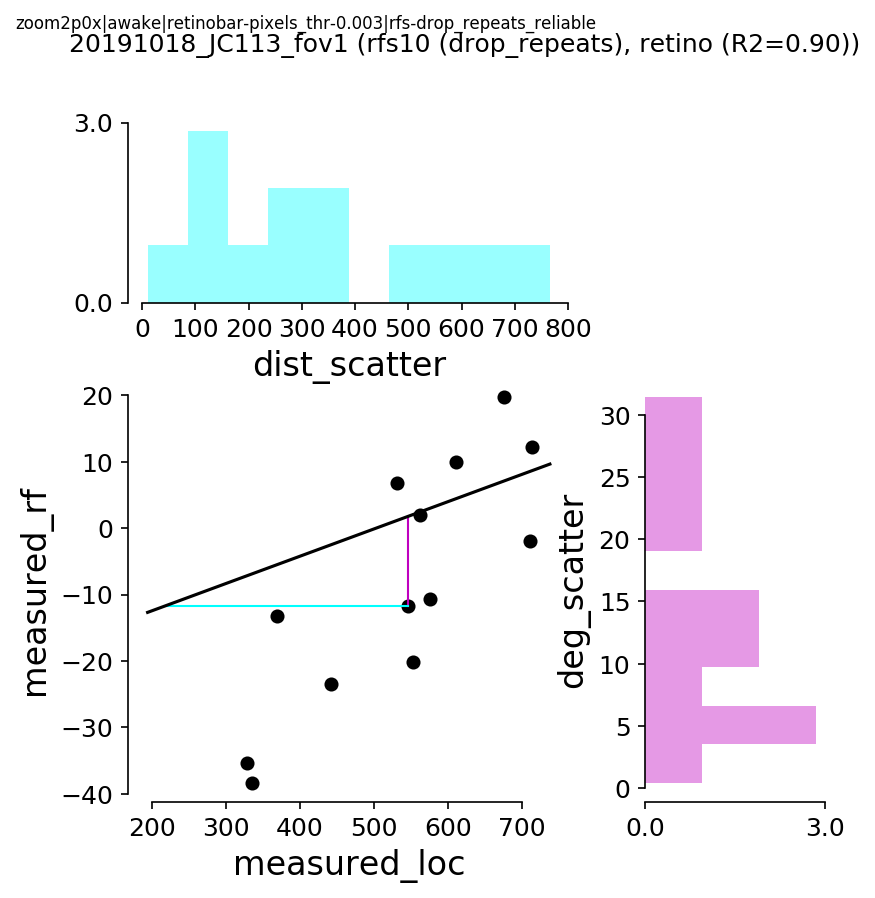

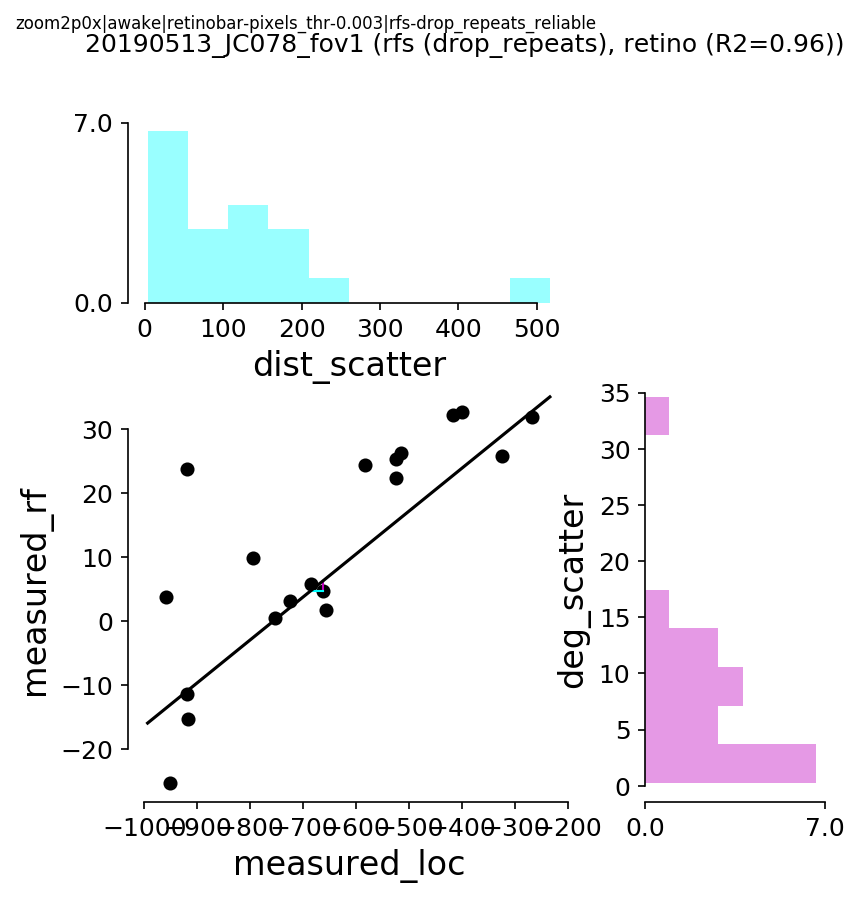

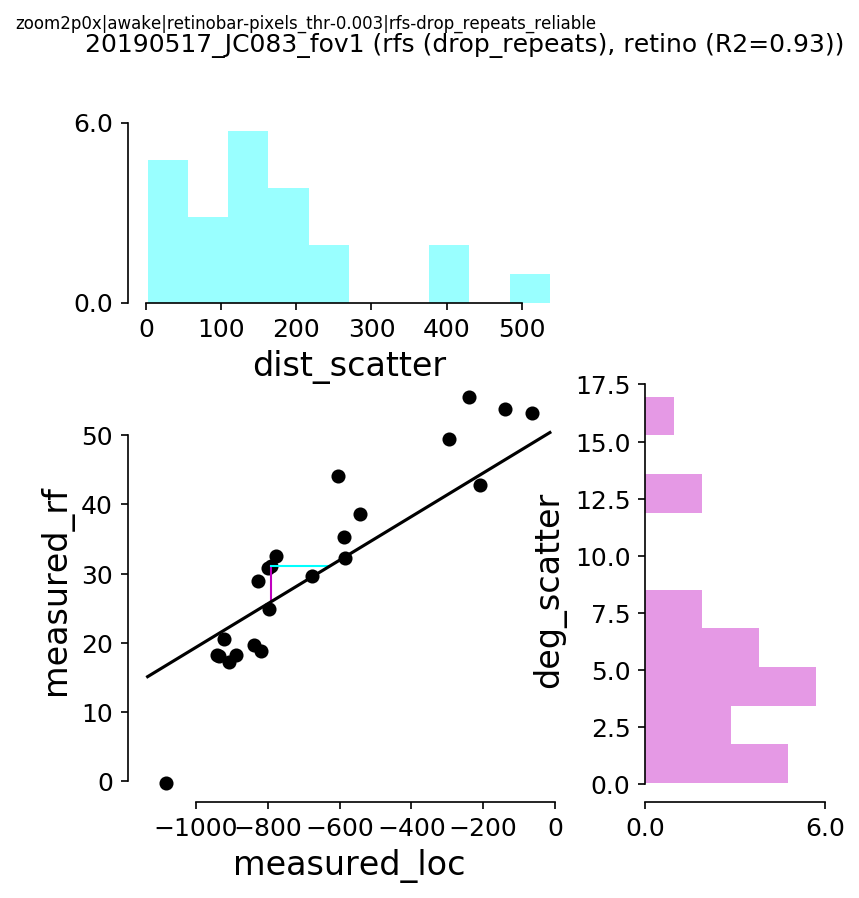

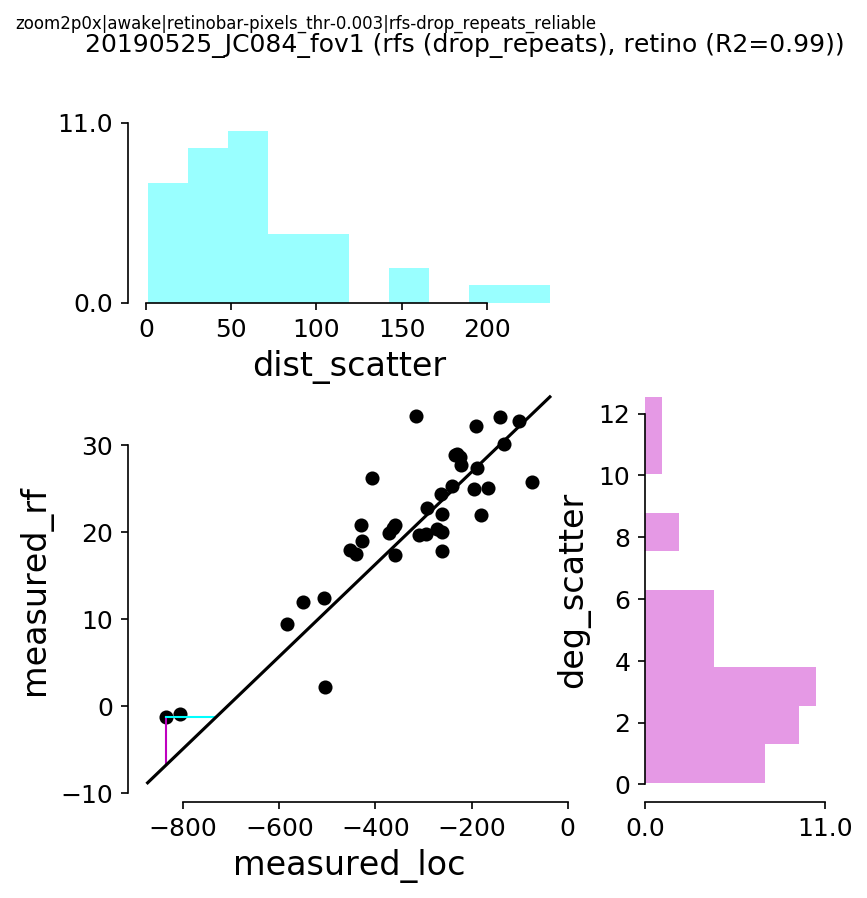

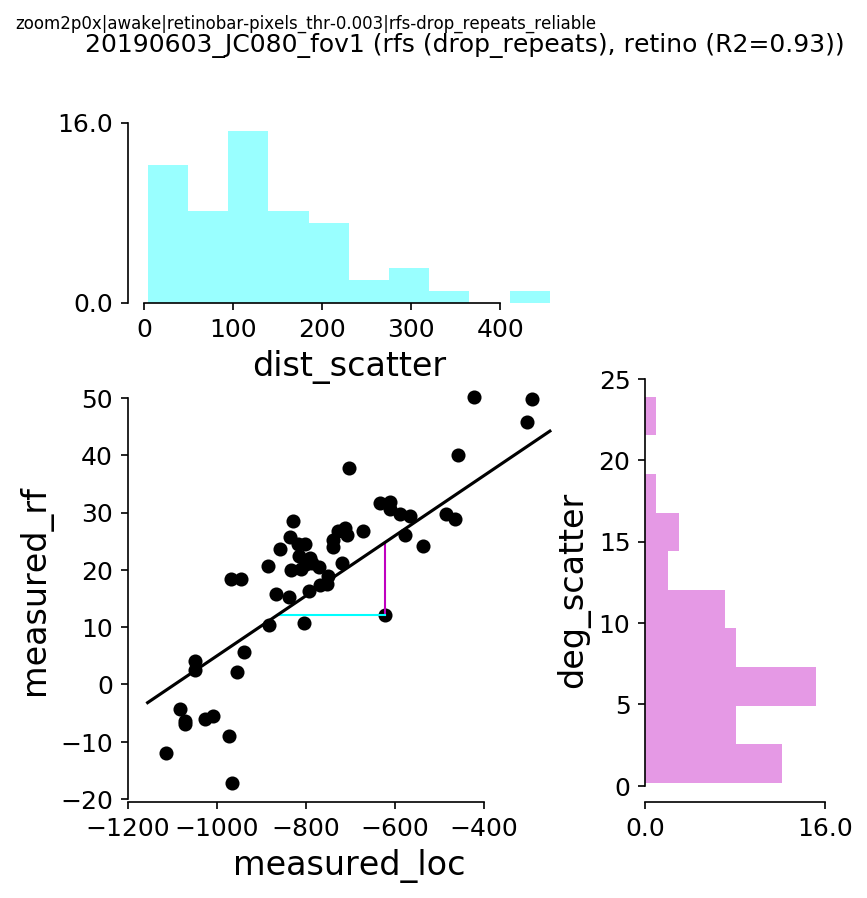

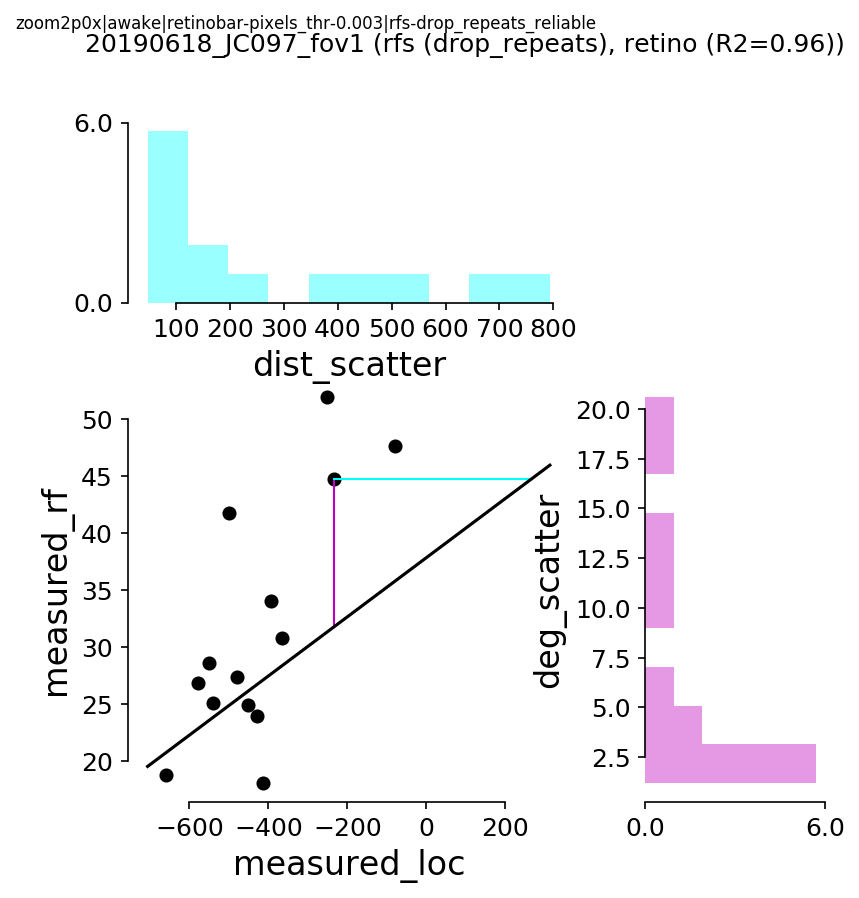

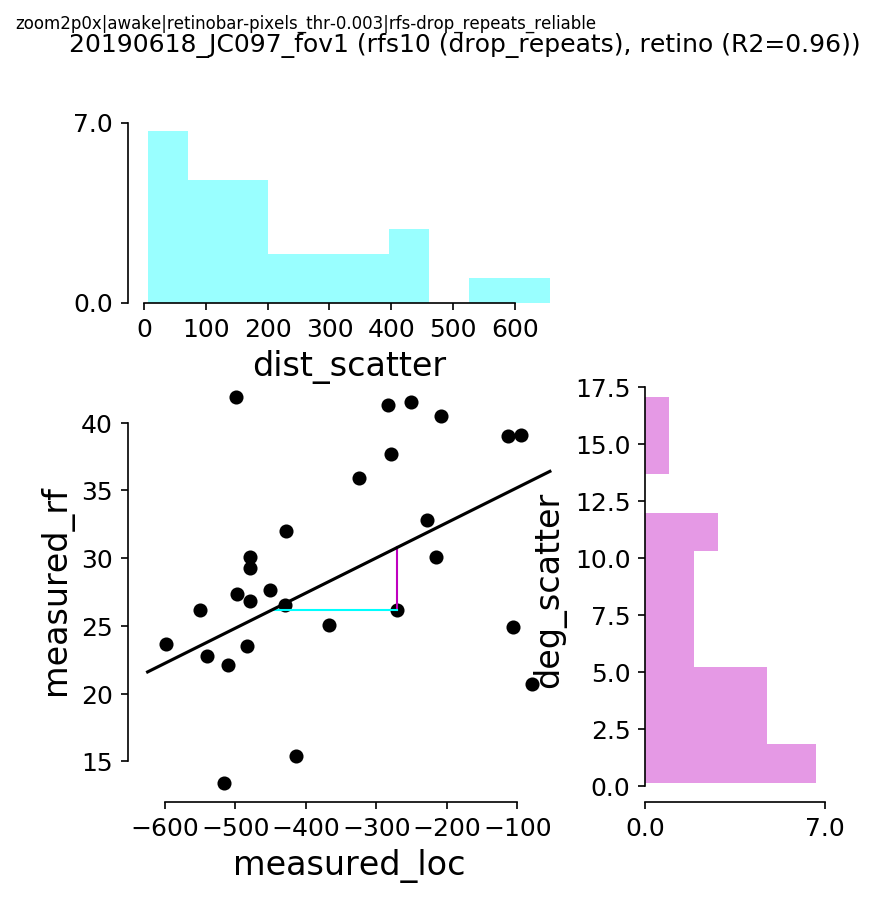

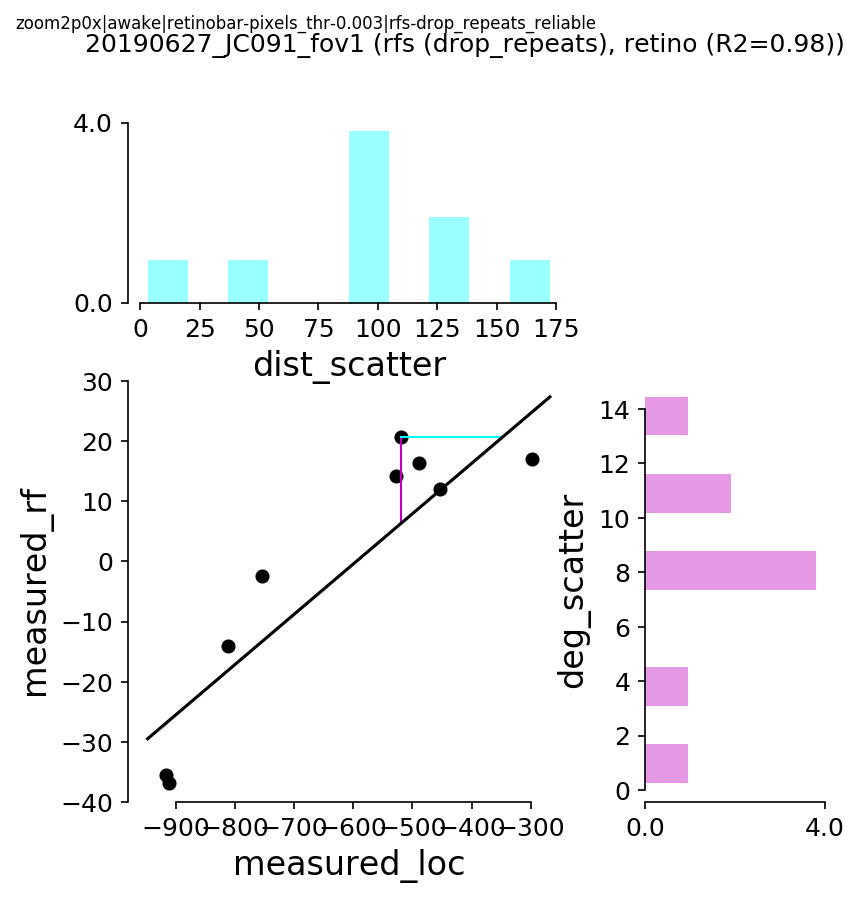

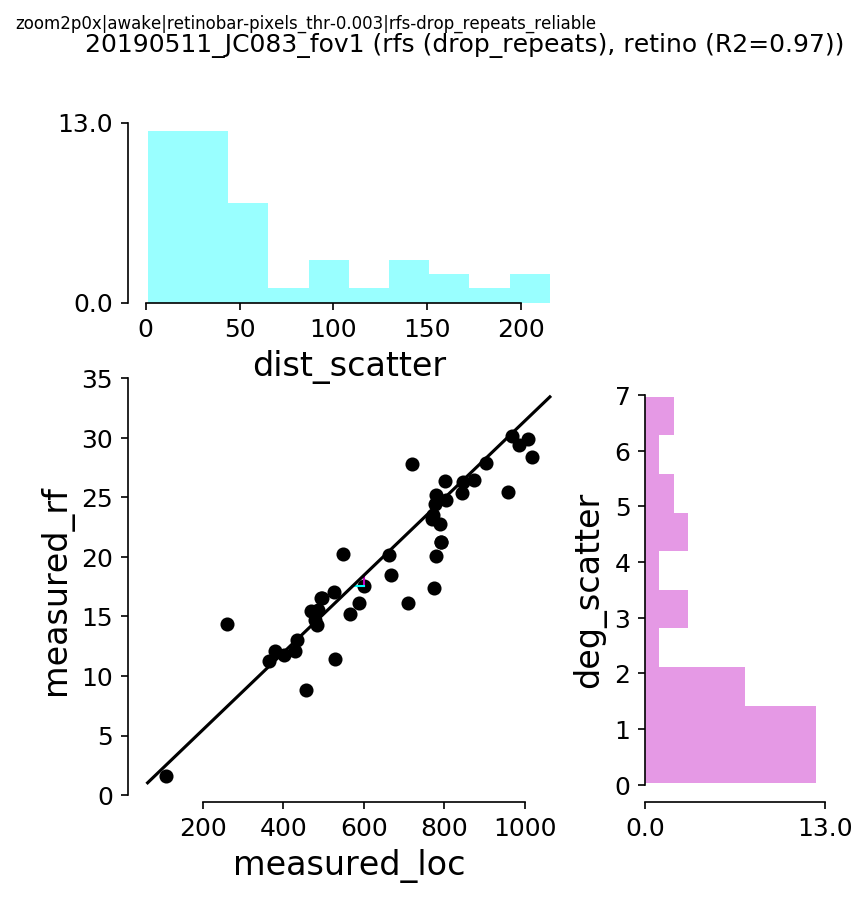

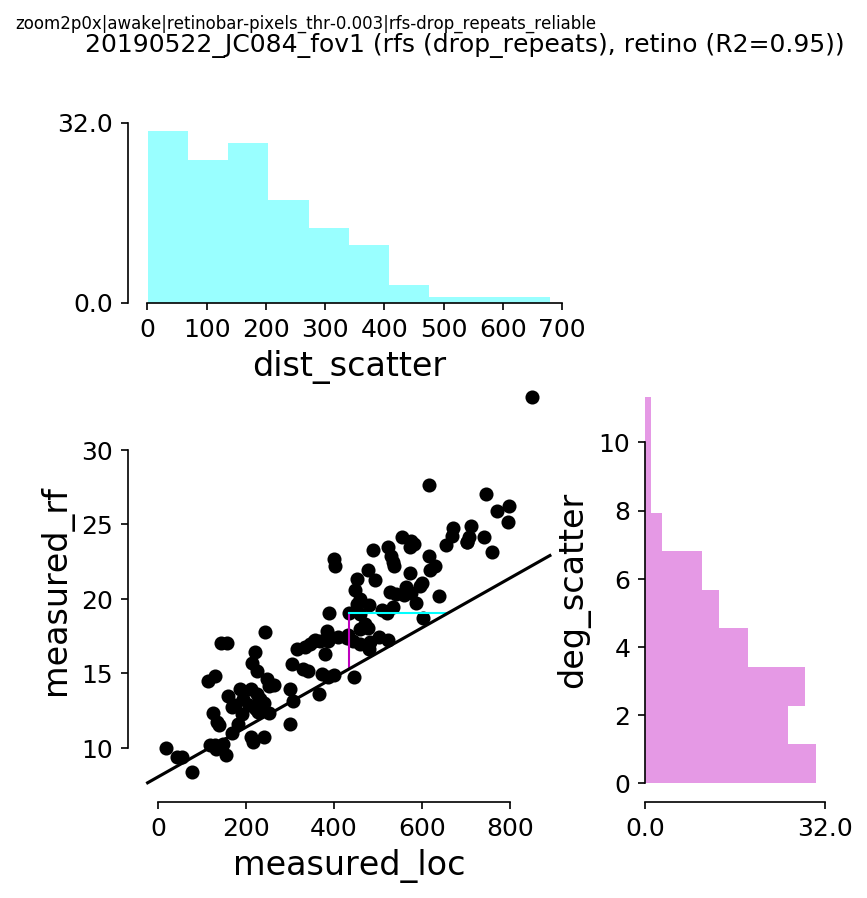

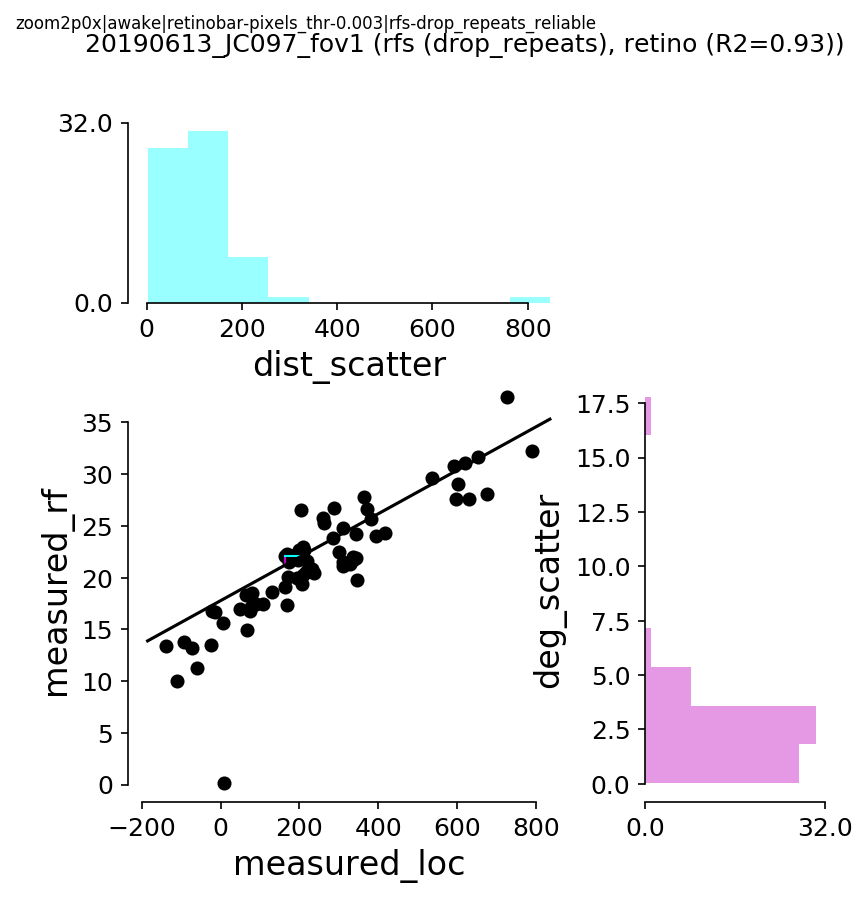

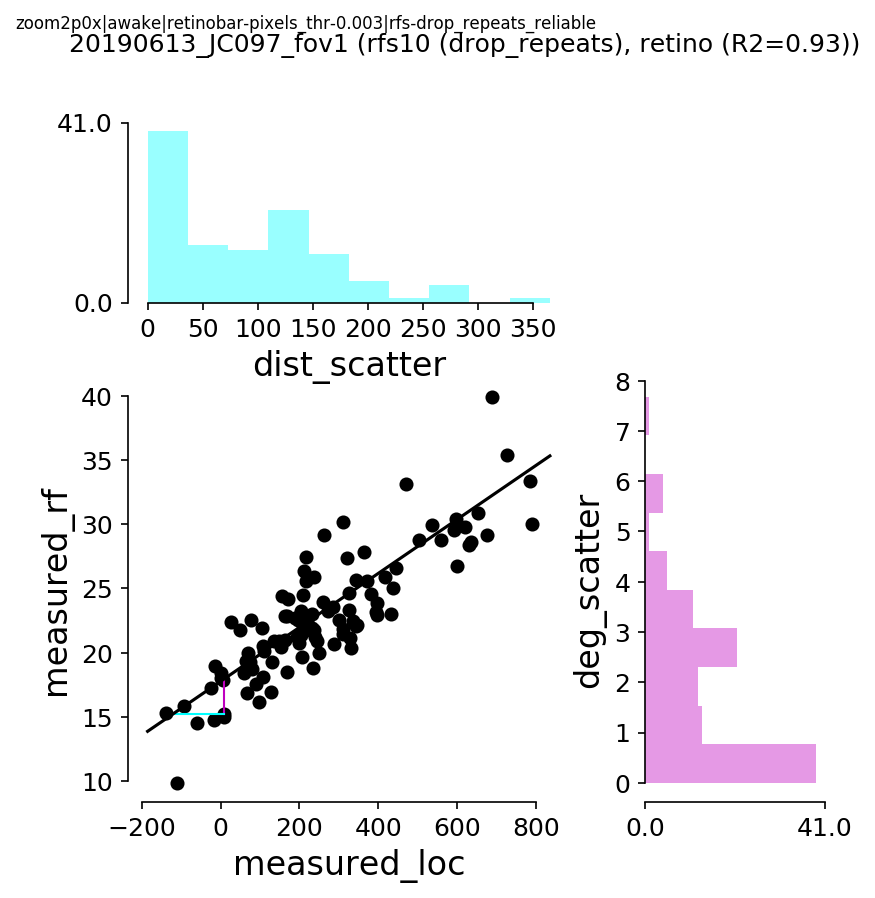

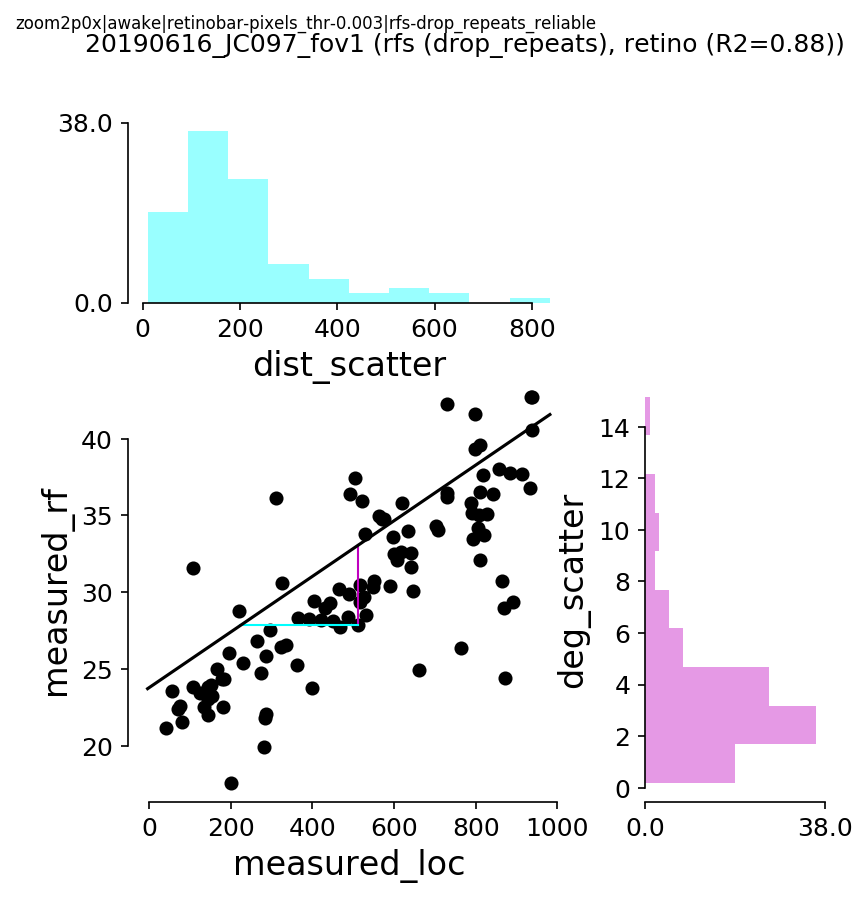

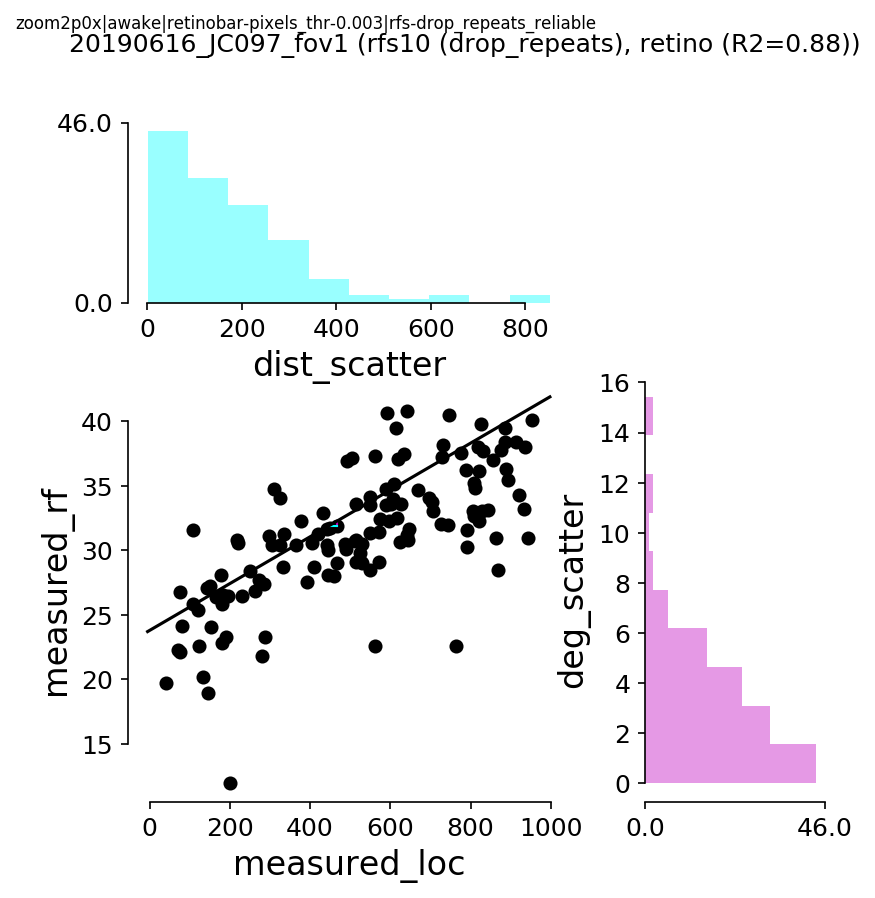

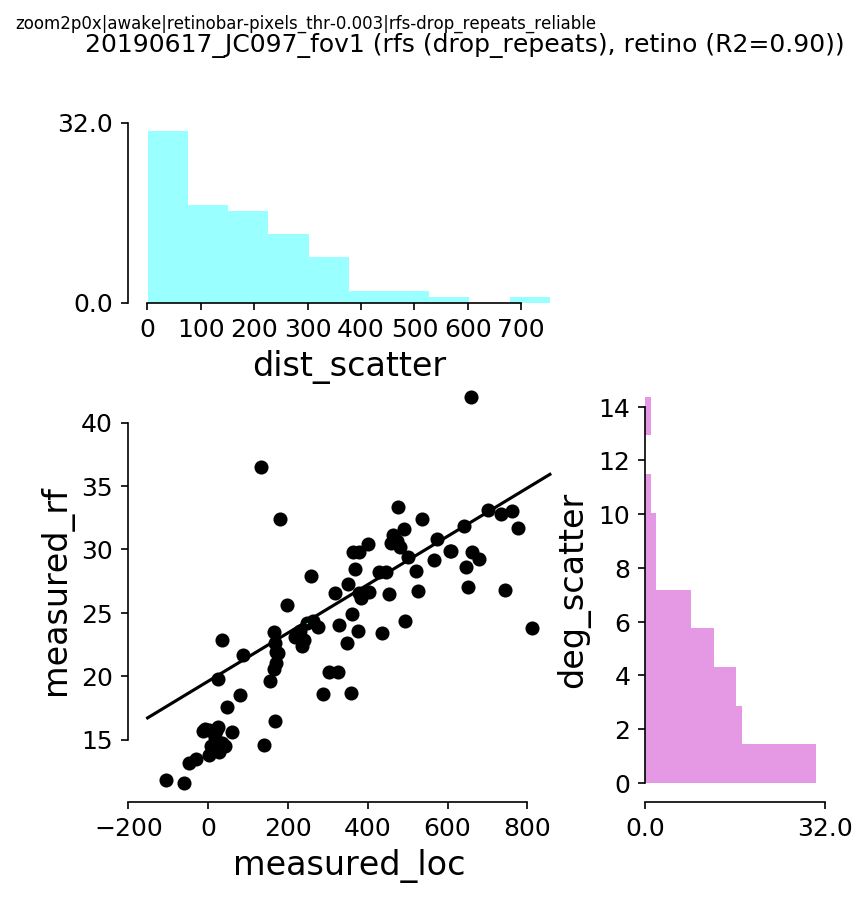

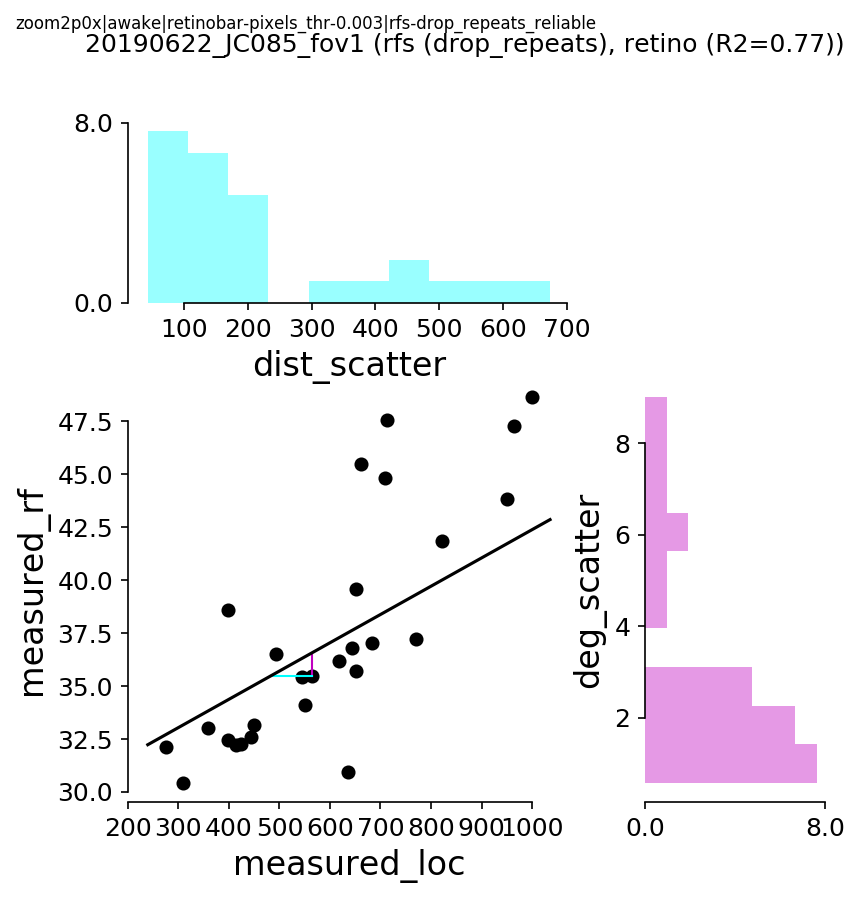

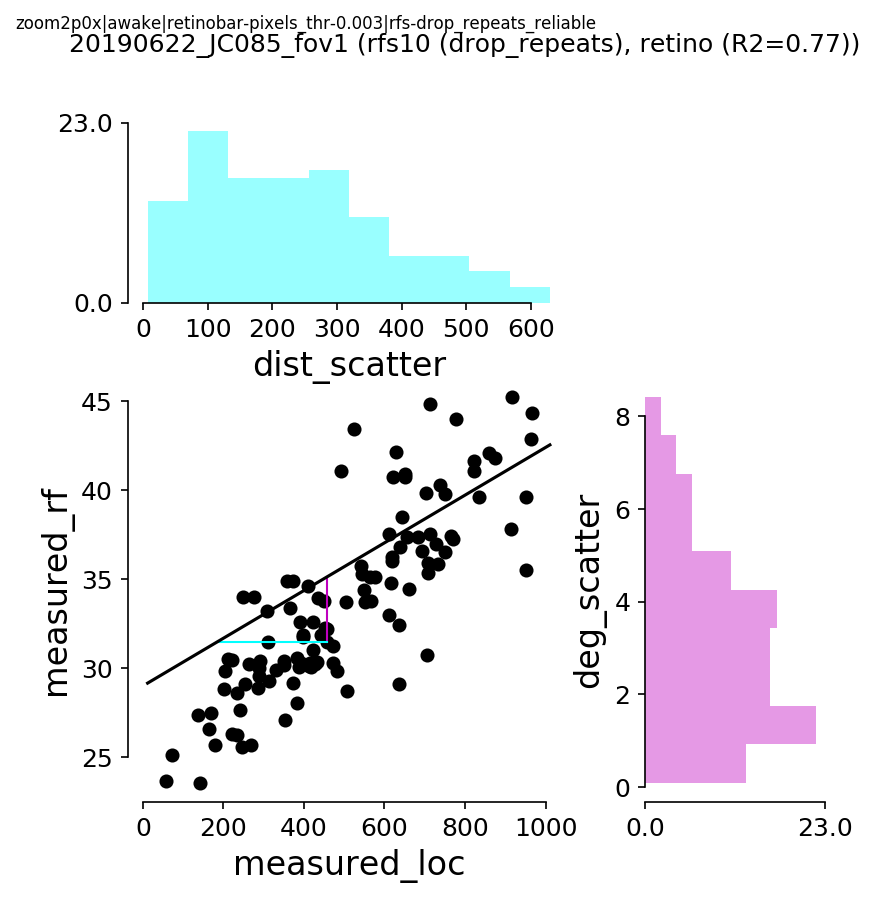

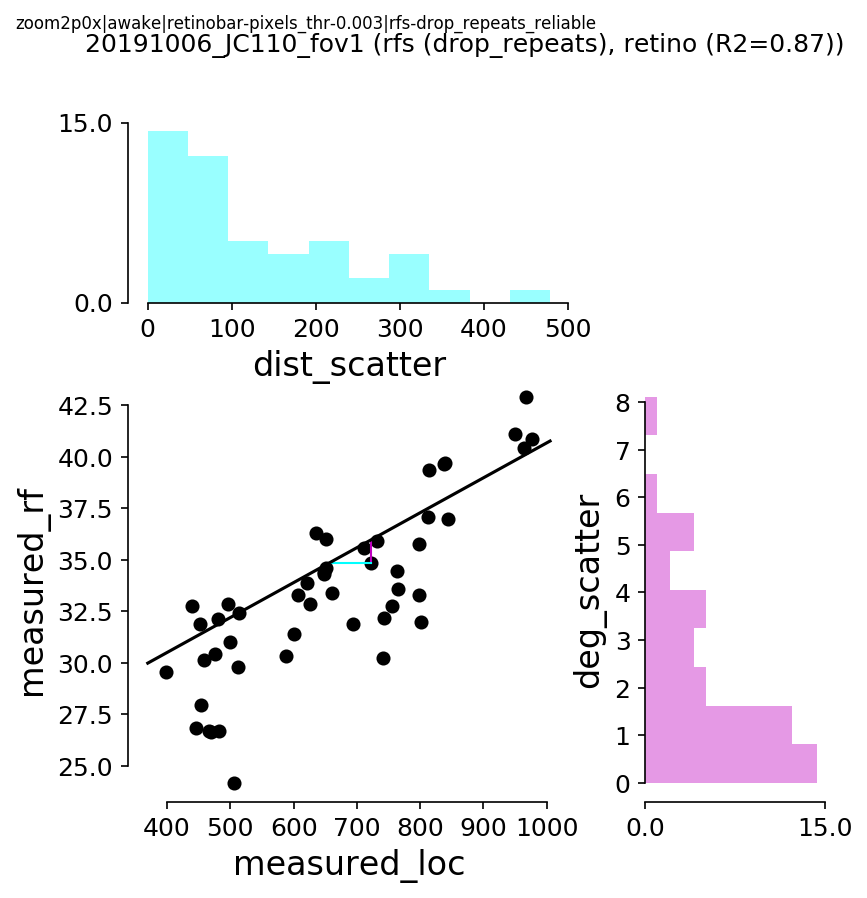

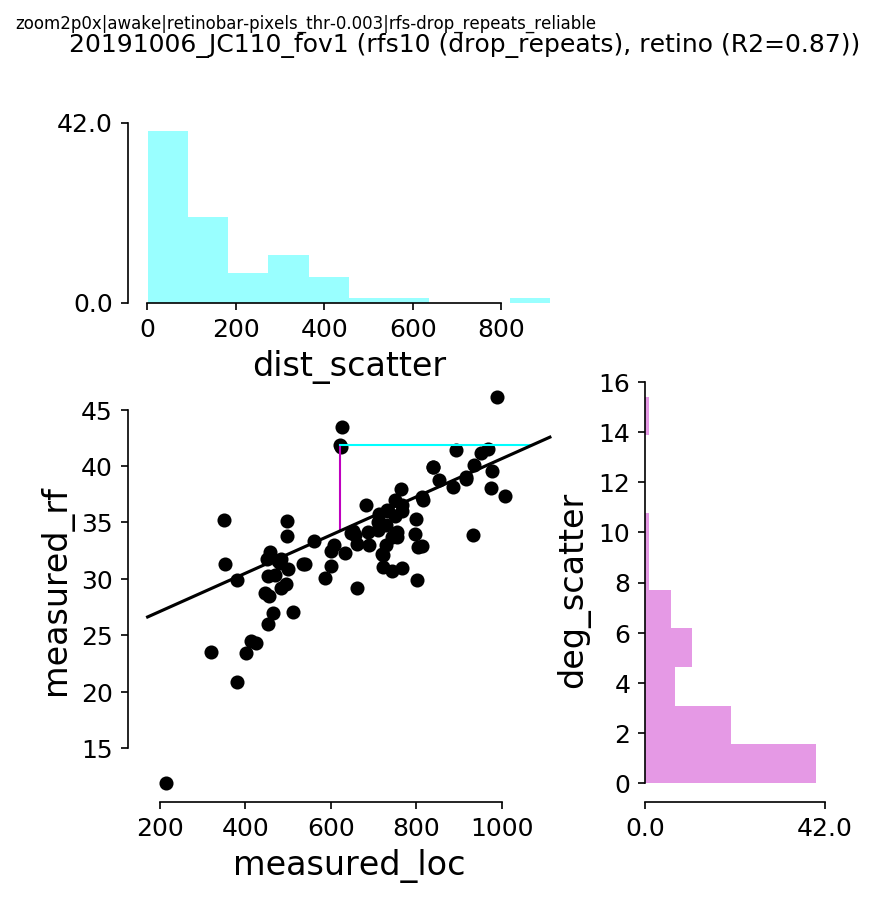

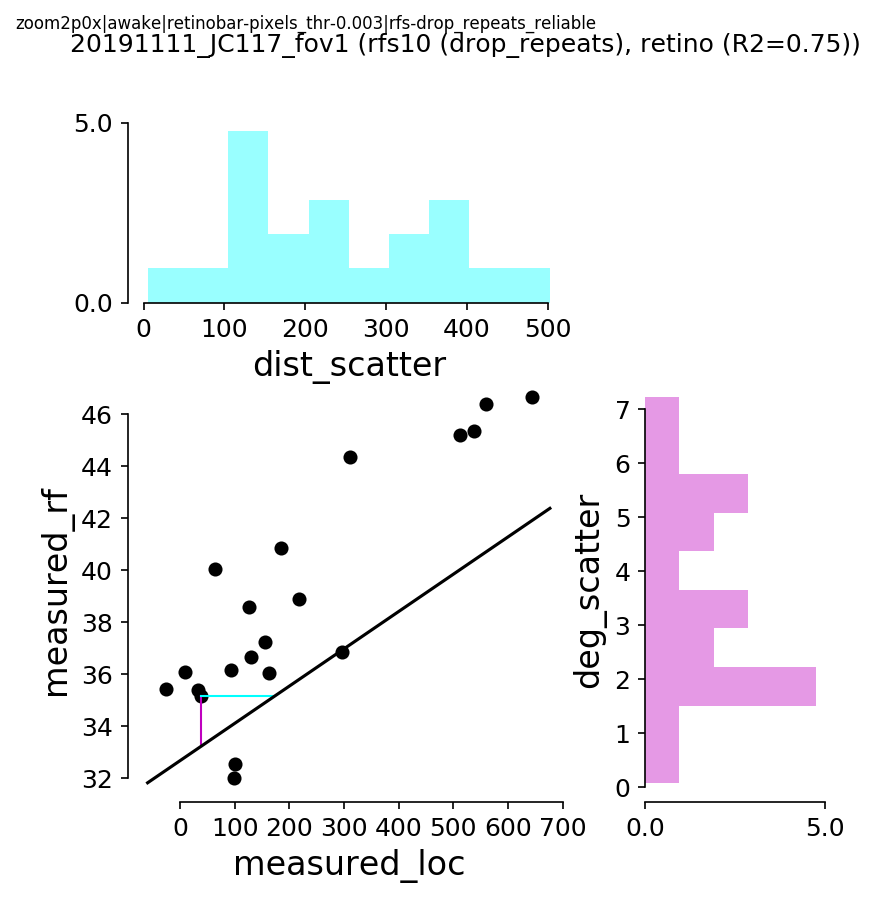

In [291]:
nbins=10
lw=1 
cond='az'

for (visual_area, datakey, rfname), rf_  in scatdf.groupby(['visual_area', 'datakey', 'rfname']):

    ret_ = projdf[projdf['datakey']==datakey]

    print(rf_.shape, ret_.shape)

    fig, scatterax = pl.subplots(figsize=(6,6), dpi=dpi)
    
    # Do scatter plot
    axdf = rf_[rf_['axis']==cond]
    sns.scatterplot(x='measured_loc', y='measured_rf', data=axdf, ax=scatterax,
                    color='k', edgecolor='k')
    slope = float(ret_[ret_['cond']==cond]['coefficient'])
    intercept = float(ret_[ret_['cond']==cond]['intercept'])
    r2_v = float(ret_[ret_['cond']==cond]['R2'])
    label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)
    ls = '-' if r2_v > retino_r2 else ':'
    
    # Plot Vert/Horz lines showing deg_scatter or dist_scatter
    npts = axdf.shape[0]
    #if npts>20:
    pt_ixs = [int(npts/2.)] #np.arange(0, npts, 10)
    for ii, (xi, yi) in enumerate(axdf[['measured_loc', 'measured_rf']].values):
        if ii not in pt_ixs:
            continue
        # Do DEG scatter
        pred_deg = axdf['predicted_rf'].iloc[ii]
        offset_deg = axdf['deg_scatter'].iloc[ii]*-1 if yi>pred_deg else axdf['deg_scatter'].iloc[ii]
        scatterax.plot([xi,xi], [yi, yi+offset_deg], 'm', alpha=1, lw=lw)
        # Do DIST scatter
        pred_dist = axdf['predicted_loc'].iloc[ii]
        offset_dist = axdf['dist_scatter'].iloc[ii]*-1 if xi>pred_dist else axdf['dist_scatter'].iloc[ii]    
        scatterax.plot([xi, xi+offset_dist], [yi, yi], 'cyan', alpha=1, lw=lw)
    # Draw regr line
    scatterax = abline(slope, intercept, ax=scatterax, ls=ls, 
                       color='k', label=False, label_prefix=label_prefix)

#     # Plot Vert/Horz lines showing deg_scatter or dist_scatter
#     for ii, (xi, yi) in enumerate(axdf[['measured_loc', 'measured_rf']].values):
#         if ii not in pt_ixs:
#             continue
#         pred_dist = axdf['predicted_loc'].iloc[ii]
#         offset_dist = axdf['dist_scatter'].iloc[ii]*-1 if xi>pred_dist else axdf['dist_scatter'].iloc[ii]    
#         scatterax.plot([xi, xi+offset_dist], [yi, yi], 'cyan', alpha=1, lw=lw)
#     scatterax = abline(slope, intercept, ax=scatterax, ls=ls, 
#                        color='k', label=False, label_prefix=label_prefix)

    # Create top/right histograms
    divider = make_axes_locatable(scatterax)
    histax_x = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
    histax_y = divider.append_axes("right", 1.2, pad=0.5, sharey=None) #scatterax)

    sns.distplot(axdf['dist_scatter'], color='cyan', ax=histax_x, kde=False, bins=nbins)
    histax_x.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_x.get_ylim()
    histax_x.set_yticks([xlim, ylim])
    histax_x.set_yticklabels([round(xlim), round(ylim)])
    histax_x.spines["right"].set_visible(False)
    histax_x.spines["left"].set_visible(True)
    histax_x.spines["top"].set_visible(False)
    histax_x.spines["bottom"].set_visible(True)


    sns.distplot(axdf['deg_scatter'], color='m', ax=histax_y, vertical=True, kde=False, bins=nbins)
    histax_y.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_y.get_xlim()
    histax_y.set_xticks([xlim, ylim])
    histax_y.set_xticklabels([round(xlim), round(ylim)])
    histax_y.spines["right"].set_visible(False)
    histax_y.spines["left"].set_visible(True)
    histax_y.spines["top"].set_visible(False)
    histax_y.spines["bottom"].set_visible(True)

    sns.despine(trim=True)
    pl.suptitle('%s (%s (%s), retino (R2=%.2f))' % (datakey, rfname, rf_filter_by, r2_v))

    label_figure(fig, data_id)

    figname = '%s_%s_%s_deg_v_dist_scatter' % (rfname, visual_area, datakey)
    pl.savefig(os.path.join(scatterfov_dir,'%s.svg' % figname))
    #print(scatterfov_dir, figname)

In [671]:
vdf_ax.head()

axis              datakey  deg_scatter  dist_scatter measured_loc  \
0   az  20190613_JC097_fov1     7.275521    334.964654      799.145   
1   az  20190613_JC097_fov1     0.057691      2.656077      476.072   
2   az  20190613_JC097_fov1     5.233501    240.950155      582.386   
3   az  20190613_JC097_fov1     2.484759    114.398174      813.273   
4   az  20190613_JC097_fov1     0.984448     45.323960      877.478   

   measured_rf  predicted_loc predicted_rf  retino_R2 visual_area  
0    39.905866    1134.109349      32.6303   0.916572          V1  
1    25.555434     473.416143      25.6131   0.916572          V1  
2    33.155796     823.336450      27.9223   0.916572          V1  
3    35.421968     927.670898      32.9372   0.916572          V1  
4    33.347307     832.153616      34.3318   0.916572          V1

In [299]:
scatter_datakeys = scatdf['datakey'].unique()
curr_rfs = rfdf[rfdf['datakey'].isin(scatter_datakeys)].copy()


In [300]:
curr_rfs.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
28  0.913706  38.255478  30.173103  5.931883  42.801776  11.264654    JC090   
29  0.788444  46.373269  23.208178  0.449038  40.726819  -4.778088    JC090   
30  0.796399  48.116725  33.703852  6.156384  43.912910  -6.139218    JC090   
31  0.815286  41.686698  44.732871  5.542592  39.027359  -3.965055    JC090   
32  0.555962  34.853207  48.102634  2.227634  25.903282  -5.486149    JC090   

    cell              datakey experiment   ...     ratio_xy   theta_c  \
28    13  20190605_JC090_fov1      rfs10   ...     1.267867 -0.351302   
29    17  20190605_JC090_fov1      rfs10   ...     1.998143  0.449038   
30    45  20190605_JC090_fov1      rfs10   ...     1.427633 -0.126801   
31    47  20190605_JC090_fov1      rfs10   ...     0.931903 -0.740594   
32    86  20190605_JC090_fov1      rfs10   ...     0.724559 -0.913959   

   fov_xpos  fov_xpos_pix  fov_ypos  fov_ypos_pix   ml_pos   ap_pos  ml_proj  \
28  548.471           238   173.238            91  799.562  629.129  358.875   
29  603.779           262   169.431            89  803.369  573.821  390.742   
30  666.001           289    281.75           148   691.05  511.599  326.799   
31  693.655           301   274.135           144  698.665  483.945   347.62   
32  410.201           178   295.076           155  677.724  767.399  183.082   

    ap_proj  
28  913.695  
29  905.822  
30  782.953  
31  784.601  
32  823.555  

[5 rows x 31 columns]

In [301]:
curr_rfs[curr_rfs['experiment']=='rfs10'].groupby(['visual_area', 'datakey']).count()


r2  fwhm_x  fwhm_y  theta   x0   y0  \
visual_area datakey                                                     
Li          20190527_JC092_fov3   42      42      42     42   42   42   
            20190605_JC090_fov1   17      17      17     17   17   17   
            20190612_JC099_fov1   40      40      40     40   40   40   
            20190617_JC099_fov1   11      11      11     11   11   11   
            20191018_JC113_fov1   13      13      13     13   13   13   
Lm          20190618_JC097_fov1   28      28      28     28   28   28   
V1          20190613_JC097_fov1  107     107     107    107  107  107   
            20190616_JC097_fov1  131     131     131    131  131  131   
            20190622_JC085_fov1  115     115     115    115  115  115   
            20191006_JC110_fov1   87      87      87     87   87   87   
            20191111_JC117_fov1   21      21      21     21   21   21   

                                 animalid  cell  experiment  fovnum   ...     \
visual_area datakey                                                   ...      
Li          20190527_JC092_fov3        42    42          42      42   ...      
            20190605_JC090_fov1        17    17          17      17   ...      
            20190612_JC099_fov1        40    40          40      40   ...      
            20190617_JC099_fov1        11    11          11      11   ...      
            20191018_JC113_fov1        13    13          13      13   ...      
Lm          20190618_JC097_fov1        28    28          28      28   ...      
V1          20190613_JC097_fov1       107   107         107     107   ...      
            20190616_JC097_fov1       131   131         131     131   ...      
            20190622_JC085_fov1       115   115         115     115   ...      
            20191006_JC110_fov1        87    87          87      87   ...      
            20191111_JC117_fov1        21    21          21      21   ...      

                                 ratio_xy  theta_c  fov_xpos  fov_xpos_pix  \
visual_area datakey                                                          
Li          20190527_JC092_fov3        42       42        42            42   
            20190605_JC090_fov1        17       17        17            17   
            20190612_JC099_fov1        40       40        40            40   
            20190617_JC099_fov1        11       11        11            11   
            20191018_JC113_fov1        13       13        13            13   
Lm          20190618_JC097_fov1        28       28        28            28   
V1          20190613_JC097_fov1       107      107       107           107   
            20190616_JC097_fov1       131      131       131           131   
            20190622_JC085_fov1       115      115       115           115   
            20191006_JC110_fov1        87       87        87            87   
            20191111_JC117_fov1        21       21        21            21   

                                 fov_ypos  fov_ypos_pix  ml_pos  ap_pos  \
visual_area datakey                                                       
Li          20190527_JC092_fov3        42            42      42      42   
            20190605_JC090_fov1        17            17      17      17   
            20190612_JC099_fov1        40            40      40      40   
            20190617_JC099_fov1        11            11      11      11   
            20191018_JC113_fov1        13            13      13      13   
Lm          20190618_JC097_fov1        28            28      28      28   
V1          20190613_JC097_fov1       107           107     107     107   
            20190616_JC097_fov1       131           131     131     131   
            20190622_JC085_fov1       115           115     115     115   
            20191006_JC110_fov1        87            87      87      87   
            20191111_JC117_fov1        21            21      21      21   

                                 ml_proj  ap_proj  


********* [rfs|median std_avg] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
********* [rfs10|median std_avg] *********
[('V1', 'Lm')] p=0.487 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.002 (fdr_bh), reject H0=True


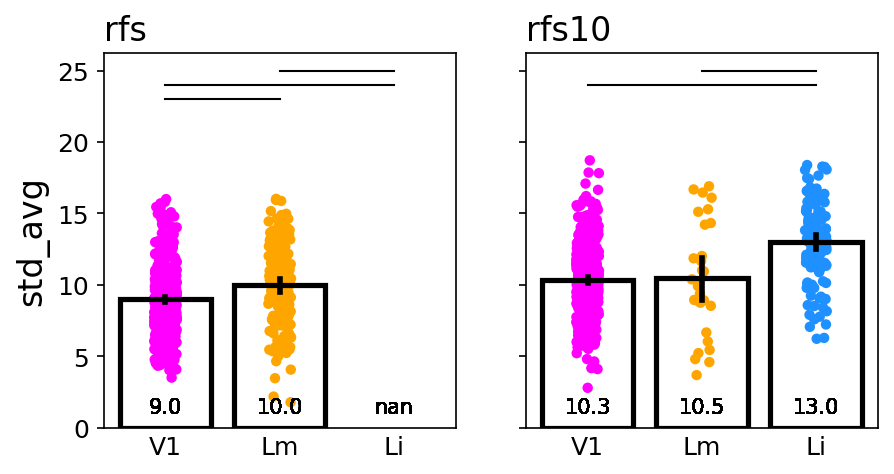

In [345]:
groupby='datakey'
curr_metric = 'std_avg'
fov_means = False
plot_bar = True

multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'median' # median


fig, axn = pl.subplots(1, 2, figsize=(6,5), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)
for ai, (ax, (experiment, expdf)) in enumerate(zip(axn.flat, curr_rfs.groupby(['experiment']))):
    ax.patch.set_alpha(0)
        
    # Average RF sizes for each FOV
    grped = expdf.groupby(['visual_area', groupby]) if groupby is not None else expdf.groupby(['visual_area'])
    mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()
    
    # Plot means
    if plot_bar:
        sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                    ax=ax, order=visual_areas, ci=95,
                    errcolor="k", edgecolor=('k', 'k', 'k'), 
                    facecolor=(1,1,1,0), linewidth=2.5)
    else:
        sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
                        ax=ax, order=visual_areas, ci=95,
                        markers='_', join=False, capsize=0., dodge=True,
                        scale=3, color='k')
    # Plot points
    plotdf = mean_sizes if fov_means else expdf
    point_size = 10 if fov_means else 5
    sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
                  zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
                  s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
                  marker='o',linewidth=1, edgecolor='none')
    
    expdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

    if ai>0:
        ax.set_ylabel('');
    ax.set_title(experiment, loc='left', fontsize=16)
    
    # Get counts of samples for legend
    #legend_elements = aggr.get_counts_for_legend(expdf, area_colors=area_colors, markersize=10, marker='_')
    #ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.4), fontsize=8)
    ax.set_xlabel(''); ax.tick_params(axis='x', size=0);
    
    # Annotate w stats
    print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
    y_loc = 16 if fov_means else 23
    statresults = aggr.do_mannwhitney(plotdf, metric=curr_metric, multi_comp_test=multi_comp_test)
    aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

# ylim = 0 if fov_means else 0
# ax.set_ylim([ylim, ax.get_ylim()[-1]])
pl.subplots_adjust(top=0.7, bottom=0.2, left=0.12, right=0.98)
# sns.despine(offset=4, trim=True, bottom=True)

# label_figure(fig, data_id)
# figname = '%s_RFvRF10_%s_multicomp-%s__%s_%s' % (curr_metric, plot_str, multi_comp_test, filter_str, bar_str)
# #pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
# print(figname)

In [322]:
scatdf.head()

axis              datakey  deg_scatter  dist_scatter measured_loc  \
0   az  20190527_JC092_fov3     4.481396     44.398004      629.847   
1   az  20190527_JC092_fov3     1.363426     13.507706      652.465   
2   az  20190527_JC092_fov3     0.637502      6.315845       620.84   
3   az  20190527_JC092_fov3     0.342061      3.388857      605.702   
4   az  20190527_JC092_fov3     1.941626     19.236043      545.999   

   measured_rf  predicted_loc predicted_rf  retino_R2 rfname visual_area  
0    13.970935     585.448948      18.4523   0.979097  rfs10          Li  
1    22.098769     665.972884      20.7353   0.979097  rfs10          Li  
2    16.905663     614.523837      17.5432   0.979097  rfs10          Li  
3    15.673189     602.313491      16.0152   0.979097  rfs10          Li  
4     8.047331     526.762728      9.98896   0.979097  rfs10          Li

********* [std_avg] *********
[('V1', 'Lm')] p=0.018 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
********* [deg_scatter] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.001 (fdr_bh), reject H0=True
rfsize_v_degscatter_plot-cells_avg-conds_fdr_bh__rfs-drop_repeats_retino-R2-0.75-both


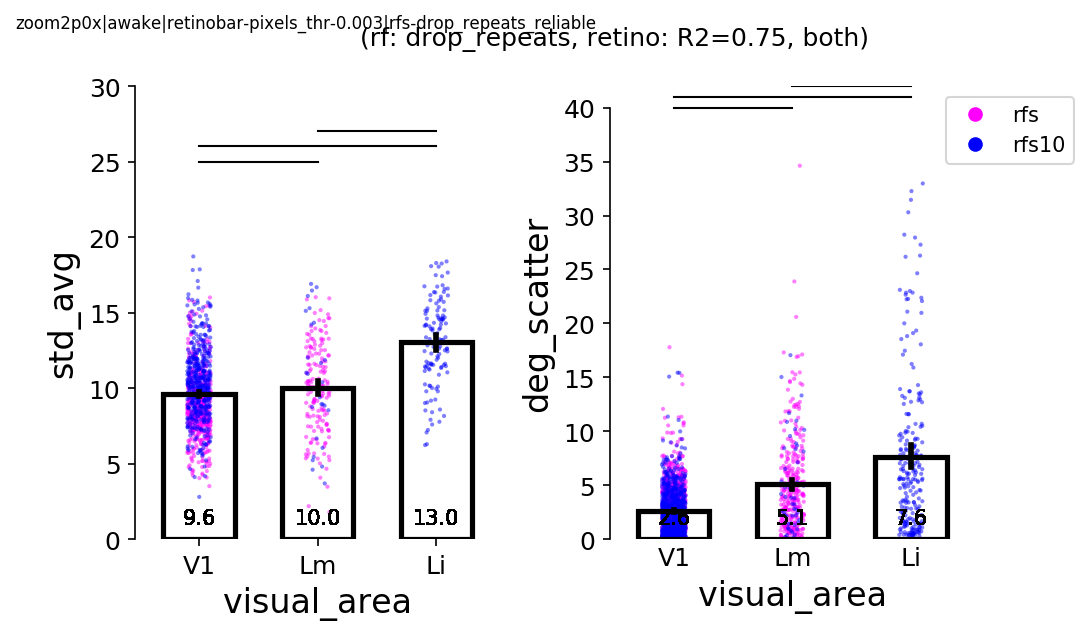

In [343]:
plot_cells=True
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']
rfcolor_dict = dict((k, v) for k, v in zip(rfnames, rfcolors))
multi_comp_test='fdr_bh'
marker_size = 2 if plot_cells else 10


plot_str = 'plot-cells' if plot_cells else 'plot-fov-means'

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

#plot_str = '' if plot_cells else 'fovmeans'
plotdf = curr_rfs.copy()
meandf = curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index()

#fig, axn = pl.subplots(1,2, figsize=(12,4))
#for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
fig, axn = pl.subplots(1, 2, figsize=(8,4), dpi=dpi, sharey=plot_cells==False)
if plot_cells:
    xdf = plotdf.copy()
else:
    xdf = meandf.copy()
    
plotter='std_avg'
ax=axn[0]
sns.barplot("visual_area", plotter, data=xdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .6)

sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['experiment']=='rfs'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs'], alpha=0.5, order=['V1', 'Lm', 'Li'])
sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['experiment']=='rfs10'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs10'], alpha=0.5, order=['V1', 'Lm', 'Li'])
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

# Annotate w stats
print("********* [%s] *********" % (plotter))
y_loc = 25 if plot_cells else 15 #if fov_means else 23
statresults = aggr.do_mannwhitney(xdf, metric=plotter, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)
if plot_cells:
    ax.set_ylim([0, 30])

plotter='deg_scatter'
plotdf = scatdf.copy()
meandf = scatdf.groupby(['visual_area', 'datakey', 'rfname']).mean().reset_index()
if plot_cells:
    xdf = plotdf.copy()
else:
    xdf = meandf.copy()
    
ax=axn[1]
sns.barplot("visual_area", plotter, data=xdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .6)

sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['rfname']=='rfs'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs'], alpha=0.5, order=['V1', 'Lm', 'Li'])
sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['rfname']=='rfs10'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs10'], alpha=0.5, order=['V1', 'Lm', 'Li'])
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

# Annotate w stats
print("********* [%s] *********" % (plotter))
y_loc = 40 if plot_cells else 15 #if fov_means else 23
statresults = aggr.do_mannwhitney(xdf, metric=plotter, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)
if plot_cells:
    ax.set_ylim([0, 42])


lines = [Line2D([0], [0], color=c, marker='o', linewidth=0, linestyle='-') for c in rfcolors]
ax.legend(lines, rfnames, bbox_to_anchor=(1.3, 1))


sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.8)  

fig.suptitle('(rf: %s, retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2, retino_pass_crit))


figname = 'rfsize_v_degscatter_%s_avg-conds_%s__rfs-%s_retino-R2-%.2f-%s' % (plot_str, multi_comp_test, rf_filter_by, retino_r2, retino_pass_crit)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [ ]:
curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index().groupby(['visual_area']).mean()

In [336]:
curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index().groupby(['visual_area']).mean()

r2     fwhm_x     fwhm_y     theta         x0        y0  \
visual_area                                                                  
Li           0.725659  36.695878  24.782851  3.402446  11.969885 -7.519402   
Lm           0.641087  27.715356  19.726997  3.082428  20.432486 -1.132121   
V1           0.662040  24.725713  20.888310  2.973510  28.547671 -1.669245   

                   cell  fovnum      std_x      std_y   fwhm_avg    std_avg  \
visual_area                                                                   
Li            98.780501     1.4  15.615267  10.545894  30.739365  13.080581   
Lm           119.879105     1.0  11.793768   8.394467  23.721176  10.094117   
V1           150.202183     1.0  10.521580   8.888642  22.807012   9.705111   

                   area  datakey_ix         fx        fy  ratio_xy   theta_c  \
visual_area                                                                    
Li           528.339053    8.800000  14.644286  4.370316  1.613396 -0.020717   
Lm           327.043466    5.714286  10.644018  4.236674  1.538102 -0.025542   
V1           303.839387    4.583333   9.410404  4.642540  1.279471  0.038967   

             fov_xpos_pix  fov_ypos_pix  
visual_area                              
Li             225.234368    253.177144  
Lm             267.771922    225.094960  
V1             182.556537    252.239169

In [ ]:
plot_cells=False
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']
rfcolor_dict = dict((k, v) for k, v in zip(rfnames, rfcolors))

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

#plot_str = '' if plot_cells else 'fovmeans'
plotdf = curr_rfs.copy()
meandf = curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index()
plotter='std_avg'

#fig, axn = pl.subplots(1,2, figsize=(12,4))
#for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
fig, ax = pl.subplots()

#if barplot:
sns.barplot("visual_area", plotter, data=plotdf, ax=ax,
           hue='experiment', order=visual_areas, errcolor="k", hue_order=rfnames,
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .4)

sns.stripplot(x='visual_area', y=plotter, hue='experiment', data=meandf, #[meandf['experiment']=='rfs'], 
              dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             palette=rfcolor_dict, alpha=0.5, order=['V1', 'Lm', 'Li'])

# sns.stripplot(x='visual_area', y=plotter, hue='experiment', data=meandf[meandf['experiment']=='rfs10'], 
#               dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
#              palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
ax.legend_.remove()

plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
#scatdf[scatdf['rfname']=='rfs'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='m')
#scatdf[scatdf['rfname']=='rfs10'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='c')

rfutils.set_split_xlabels(ax, a_label=rfnames[0], b_label=rfnames[1])
#ax.legend_.remove()


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in rfcolors]
ax.legend(lines, rfnames)


sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  

fig.suptitle('RF %s size (RF: %s, Retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2, retino_pass_crit))

## Select best Retino, and either rfs/rfs10. Plot projected fov vs. orig fov position

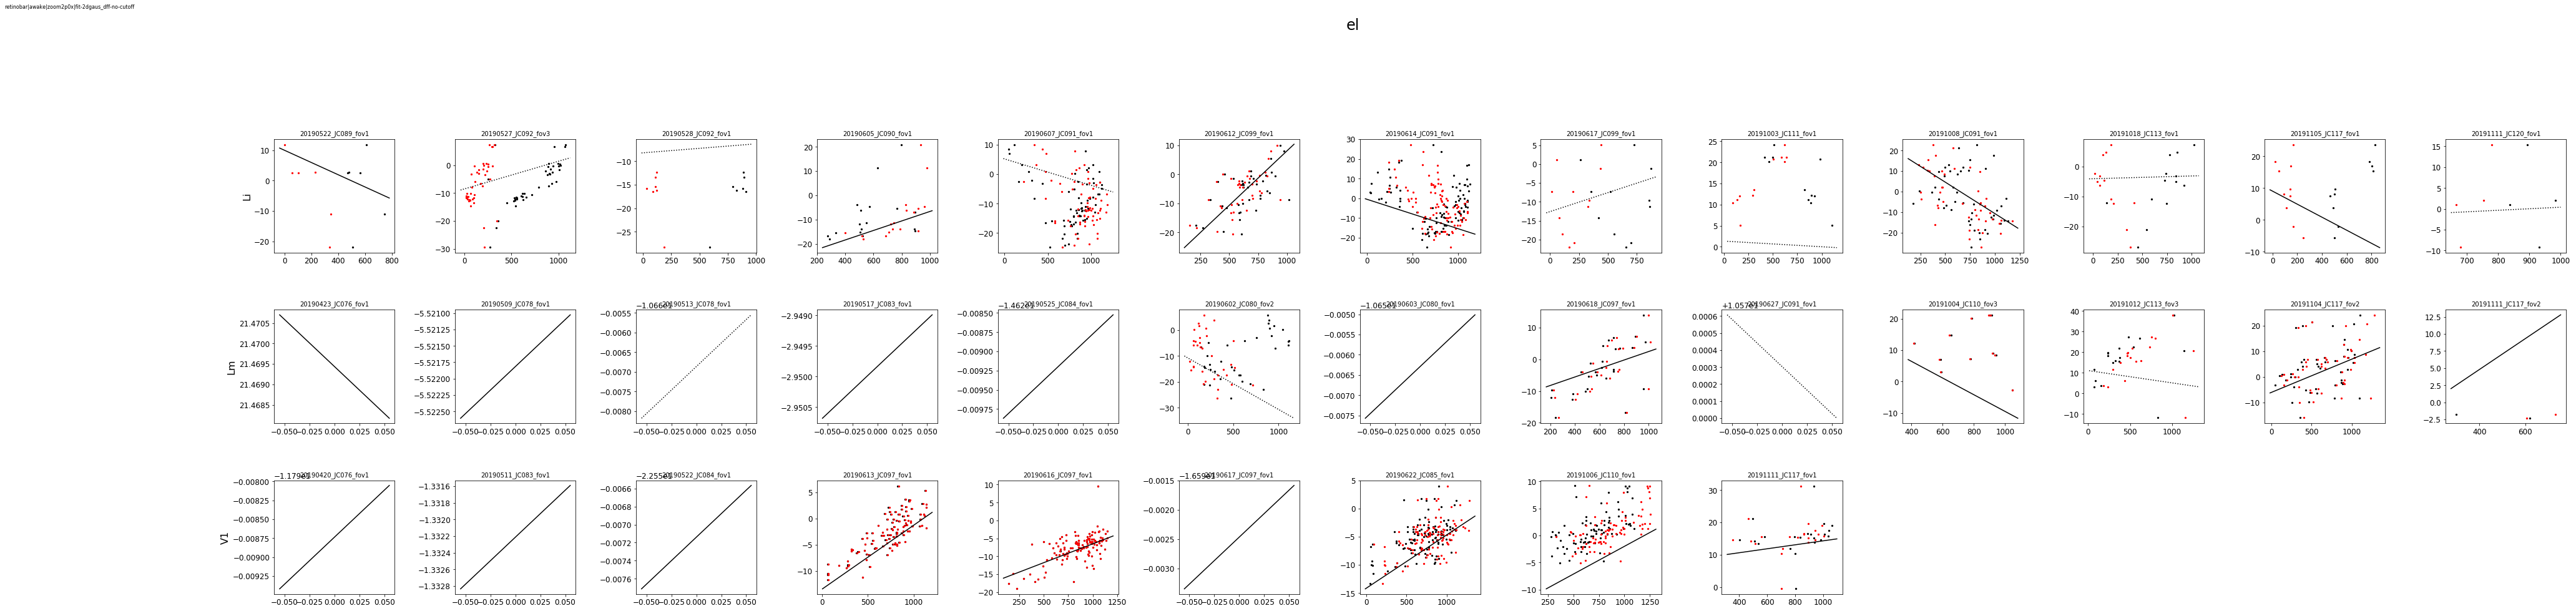

In [204]:
cond = 'el'
rfname = 'rfs10'
alt_rfname = 'rfs10' if rfname=='rfs' else 'rfs10'

rep_colors=['blue', 'orange']

xname = 'ml' if cond=='az' else 'ap'
yname = 'x0' if cond=='az' else 'y0'
    
max_nfovs = int(rfdf[['visual_area','datakey']].drop_duplicates().groupby(['visual_area']).count().max())

fig, axn = pl.subplots(3, max_nfovs, figsize=(60,15))
for ri, (visual_area, vdf) in enumerate(rfdf.groupby(['visual_area'])):
    for ci, (datakey, ddf) in enumerate(vdf.groupby(['datakey'])):
        
        ax = axn[ri, ci]
        if ci==0:
            ax.set_ylabel(visual_area, fontsize=16)
        #for col, (exp, edf) in zip(rep_colors, ddf.groupby(['experiment'])):

        # Plot RF positions vs. cell locs
        edf = ddf[ddf['experiment']==rfname].copy()
        if len(edf)==0:
            edf = ddf[ddf['experiment']==alt_rfname].copy()
            #rfname = alt_rfname
        
        cell_locs = edf['%s_pos' % xname].values
        rf_locs = edf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k')
        
        # plot projected
        cell_locs = edf['%s_proj' % xname].values
        rf_locs = edf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='r')

        # Plot retino direction
        p_df = projdf[projdf['datakey']==datakey]
        retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
        g = p_df[p_df['retinorun']==retinorun].copy()
        
        slope = float(g[g['cond']==cond]['coefficient'])
        intercept = float(g[g['cond']==cond]['intercept'])
        ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
        r2_v = float(g[g['cond']==cond]['R2'])
        label_prefix = '%s (R2=%.2f)' % (retinorun.split('_')[-1], r2_v) if len(p_df)>2 else ''
        label = len(regdf_vs)>2
        ax = abline(slope, intercept, ax=ax, color='k',
                    label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title(datakey, fontsize=10)
    
    if ci < (max_nfovs-1):
        for ci in np.arange(ci+1, max_nfovs):
            axn[ri, ci].axis('off')
ax.legend()

pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, top=0.8)
pl.suptitle(cond, fontsize=24)

label_figure(fig, data_id)

figname = '%s_retinogradient_v_rfpos_v_fovpos_%s__%s_magthr-%.2f-%s' % (rfname, cond, filter_str, mag_thr, pass_criterion)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis','%s.svg' % figname))

## Plot all RFs and Retino Runs by session 

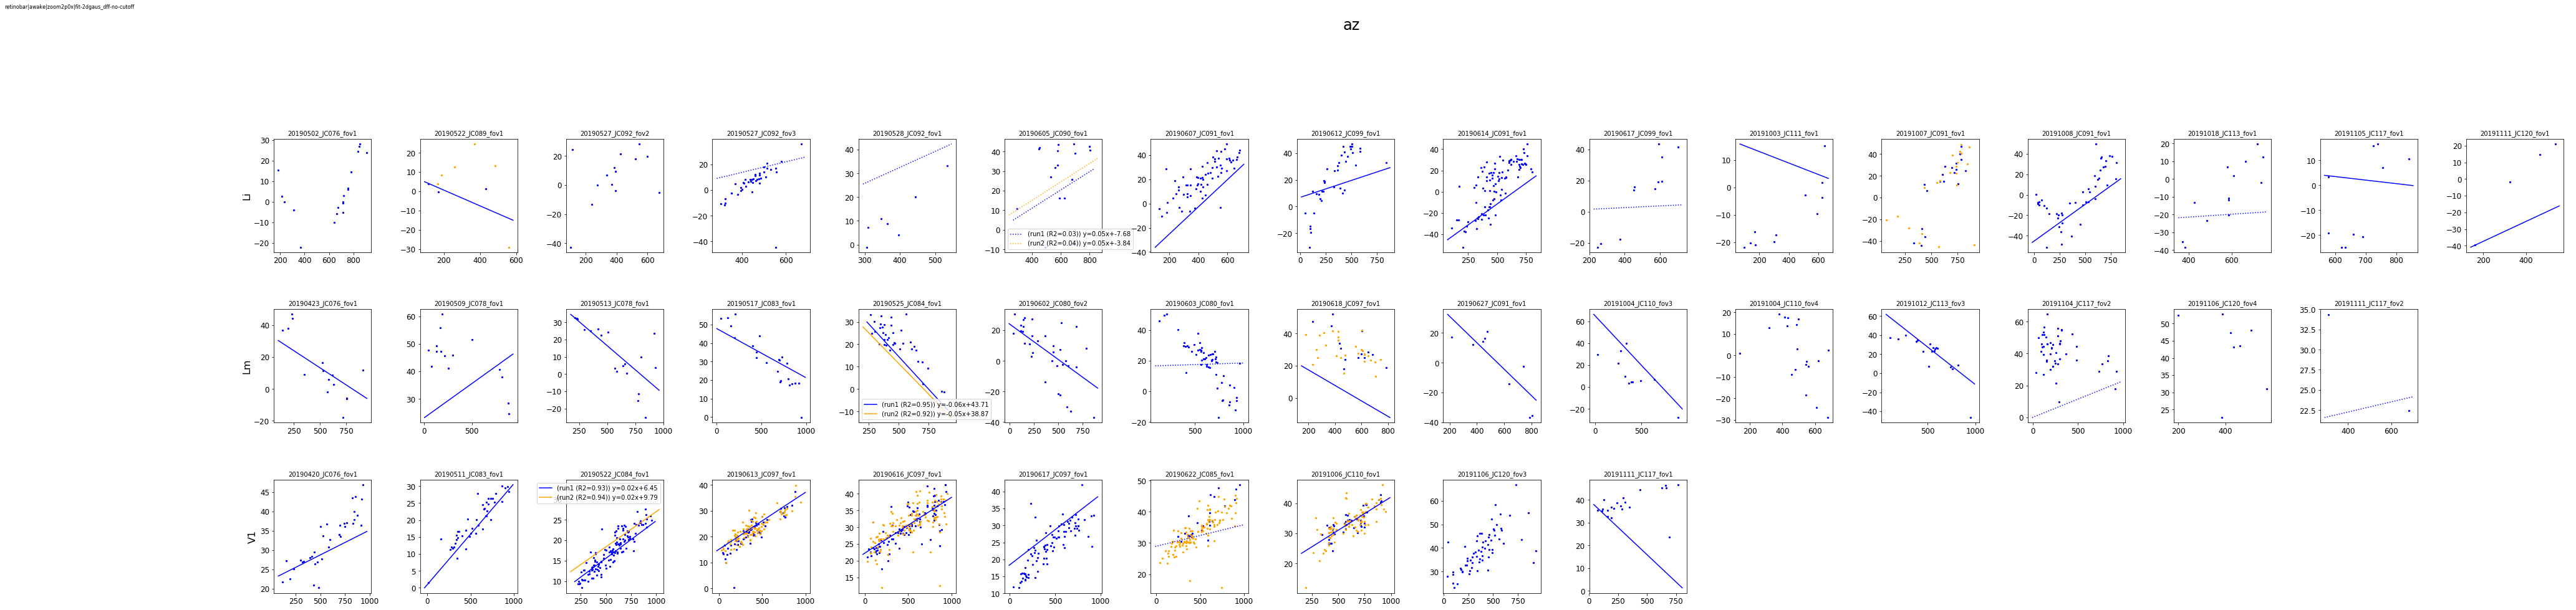

In [188]:
cond = 'az'
rep_colors=['blue', 'orange']

xname = 'ml_pos' if cond=='az' else 'ap_pos'
yname = 'x0' if cond=='az' else 'y0'
    
max_nfovs = int(r_df[['visual_area','datakey']].drop_duplicates().groupby(['visual_area']).count().max())

fig, axn = pl.subplots(3, max_nfovs, figsize=(60,15))
for ri, (visual_area, vdf) in enumerate(r_df.groupby(['visual_area'])):
    for ci, (datakey, ddf) in enumerate(vdf.groupby(['datakey'])):

        ax = axn[ri, ci]
        if ci==0:
            ax.set_ylabel(visual_area, fontsize=16)
        for col, (exp, edf) in zip(rep_colors, ddf.groupby(['experiment'])):

            # Plot RF positions vs. cell locs
            cell_locs = edf[xname].values
            rf_locs = edf[yname].values
            ax.scatter(cell_locs, rf_locs, marker='o', s=5, color=col)

        # Plot retino direction
        regdf_vs = projdf[projdf['datakey']==datakey]
        for col, (retinorun, g) in zip(rep_colors, regdf_vs.groupby(['retinorun'])):
            slope = float(g[g['cond']==cond]['coefficient'])
            intercept = float(g[g['cond']==cond]['intercept'])
            ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
            r2_v = float(g[g['cond']==cond]['R2'])
            label_prefix = '%s (R2=%.2f)' % (retinorun.split('_')[-1], r2_v) if len(regdf_vs)>2 else ''
            label = len(regdf_vs)>2
            ax = abline(slope, intercept, ax=ax, color=col,
                        label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title(datakey, fontsize=10)
    
    if ci < (max_nfovs-1):
        for ci in np.arange(ci+1, max_nfovs):
            axn[ri, ci].axis('off')
ax.legend()

pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, top=0.8)
pl.suptitle(cond, fontsize=24)

label_figure(fig, data_id)

figname = 'inspect_retinogradient_v_rfpos_v_fovpos_%s__%s_magthr-%.2f-%s' % (cond, filter_str, mag_thr, pass_criterion)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis','%s.svg' % figname))

In [189]:
projection_df[projection_df['datakey']=='20190607_JC091_fov1']

R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
0  0.973328  4.286557     0.111963   az -47.418096        0.0   0.986574   
1  0.418045  3.133284    -0.008981   el   5.184302        0.0  -0.646564   

  animalid   session            fov    retinorun     retinoid  \
0    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   
1    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   

               datakey                                              fpath  \
0  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   
1  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   

  visual_area  abs_coef  
0          Li  0.111963  
1          Li  0.008981

In [190]:
datakey = '20190607_JC091_fov1'
#retinorun = 'retino_run1'

p_df = projection_df[projection_df['datakey']==datakey]
# Load 1 fov to test sth
# fpath = [p for p in proj_fit_paths if p[0]=='JC091' and p[1]=='20190607' and p[3]==retinorun][0][5]
# with open(fpath, 'rb') as f:
#     res = pkl.load(f)
# print(res['regr_az'].coef_, res['regr_az'].intercept_)

# p_df = res['regr_df'].copy()


retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
fpath = p_df[p_df['retinorun']==retinorun]['fpath'].unique()[0]
gpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(gpath, 'rb') as f:
    gresults = pkl.load(f)

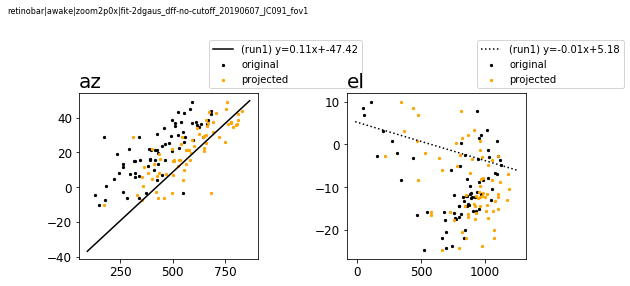

In [192]:
#datakey = '20190522_JC084_fov1' #'20190607_JC091_fov1'
#retinorun = 'retino_run1'
rfname = 'rfs10'

p_df = projdf[projdf['datakey']==datakey]
retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']

g = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
edf = rfdf[(rfdf['datakey']==datakey) & (rfdf['experiment']==rfname)]

fig, axn = pl.subplots(1,2, figsize=(8,4))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml' if cond=='az' else 'ap'
    yname = 'x0' if cond=='az' else 'y0'

    # Plot RF positions vs. cell locs
    cell_locs = edf['%s_pos' % xname].values
    rf_locs = edf[yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')
    
    proj_locs = edf['%s_proj' % xname].values
    ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')
    
    proj_locs2 = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
                             for ap, ml in edf[['ap_pos', 'ml_pos']].values]))


    # proj_locs = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
    #                           for ap, ml in edf[['ap_pos', 'ml_pos']].values]))
    #ax.scatter(proj_locs2, rf_locs, marker='o', s=5, color='blue')

    # plot gradient line
    slope = float(g[g['cond']==cond]['coefficient'])
    intercept = float(g[g['cond']==cond]['intercept'])
    ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
    label_prefix = retinorun.split('_')[1]
    label = True
    ax = abline(slope, intercept, ax=ax, color='k',
                label=label, label_prefix=label_prefix, ls=ls)
    ax.set_title(cond, loc='left', fontsize=20)
    
    ax.legend(bbox_to_anchor=(0.7, 1), loc='top')
    
pl.subplots_adjust(top=0.7, wspace=0.5)

label_figure(fig, '%s_%s' % (data_id, datakey))

In [193]:
g

R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
0  0.973328  4.286557     0.111963   az -47.418096        0.0   0.986574   
1  0.418045  3.133284    -0.008981   el   5.184302        0.0  -0.646564   

  animalid   session            fov    retinorun     retinoid  \
0    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   
1    JC091  20190607  FOV1_zoom2p0x  retino_run1  analysis002   

               datakey                                              fpath  \
0  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   
1  20190607_JC091_fov1  /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...   

  visual_area  abs_coef  
0          Li  0.111963  
1          Li  0.008981

In [630]:
proj_ = [np.dot(np.array((ap, ml)), gresults['el']['vhat']) for ap, ml in edf[['ap_pos', 'ml_pos']].values]



[1265.2474336870805,
 1306.7746604873687,
 1220.4113895819639,
 1111.3053426323288,
 1099.6193022330513,
 1093.6652739832678,
 1056.9476933257663,
 1015.6602439137907,
 990.40668755527713,
 1006.5293870488546,
 1019.7771998236738,
 1021.1258367429371,
 1081.1799756229473,
 988.56073457136483,
 997.45181404798802,
 975.52605725282399,
 901.64686373724146,
 879.57901663789187,
 754.36803148270235,
 726.79906897816022,
 589.01519999303241,
 505.23375455400378,
 719.83386828155369,
 862.66716079778098,
 878.95859252757896,
 784.69765330435064,
 747.82022105464046,
 758.15762453465459,
 903.43953285708426,
 699.47876450594276,
 670.07272966149981,
 725.92998683552287,
 709.92273571409578,
 673.12522926049019,
 648.16473415435871,
 674.66924034800832,
 638.00494355457636,
 573.33653270003447,
 532.19117359224447,
 523.50434892788769,
 464.78996632312948,
 444.19508515920552,
 473.66328451172956,
 281.61057266015501,
 720.26901983812149,
 627.64977878653906,
 787.87448191950318,
 739.54190601

In [610]:
float(g[g['cond']==cond]['intercept'])

6.461437259218765

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


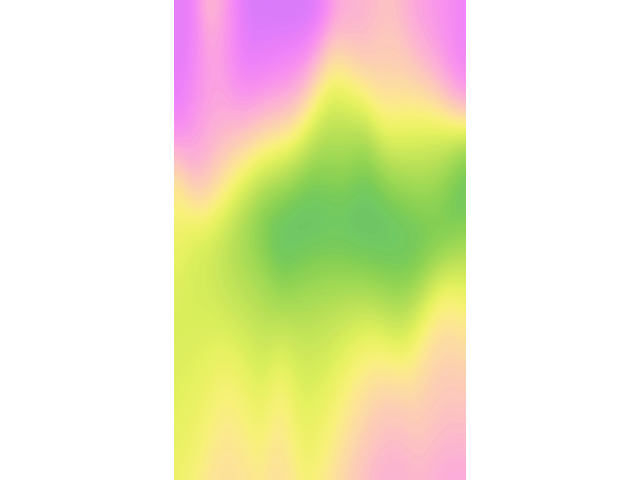

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

# Save legends